# Regression with a Mohs Hardness Dataset

Kaggle competition link: https://www.kaggle.com/competitions/playground-series-s3e25/data?select=train.csv



---



---



## Imports

In [19]:
!pip install optuna -q

In [20]:
!pip install catboost

In [38]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import optuna

from sklearn.metrics import median_absolute_error
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.base import clone
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import StackingRegressor

In [22]:
from google.colab import drive
drive.mount('/content/drive')
train_df = pd.read_csv('/content/drive/My Drive/Mohs Hardness/train.csv')
test_df = pd.read_csv('/content/drive/My Drive/Mohs Hardness/test.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
train_df.head()

,id,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
0,0,100.0,0.841611,10.0,4.8,20.612526,11.08810,2.766,1.732,0.860,0.496070,0.91457,6.0
1,1,100.0,7.558488,10.0,4.8,20.298893,12.04083,2.755,1.631,0.910,0.492719,0.71760,6.5
2,2,76.0,8.885992,15.6,5.6,33.739258,12.08630,2.828,1.788,0.864,0.481478,1.50633,2.5
3,3,100.0,8.795296,10.0,4.8,20.213349,10.94850,2.648,1.626,0.936,0.489272,0.78937,6.0
4,4,116.0,9.577996,11.6,4.8,24.988133,11.82448,2.766,1.682,0.896,0.492736,1.86481,6.0


In [24]:
test_df.head()

,id,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average
0,10407,884.0,121.420000,35.36,5.28,82.561240,9.370384,2.298,1.9072,1.200000,0.461899,1.79459
1,10408,90.0,9.931960,18.00,5.60,39.568056,12.086300,2.868,1.6520,0.864000,0.476196,1.41194
2,10409,116.0,7.767992,11.60,4.80,23.231818,11.023840,2.644,1.7940,0.960000,0.499514,0.78834
3,10410,100.0,9.107996,10.00,4.80,20.298893,12.086300,2.828,1.6620,0.792000,0.495796,1.20466
4,10411,55.0,4.030000,11.00,4.00,22.977675,11.280950,2.455,1.7500,0.893333,0.476095,0.93456


## Dataset overview

In [25]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10407 entries, 0 to 10406
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     10407 non-null  int64  
 1   allelectrons_Total     10407 non-null  float64
 2   density_Total          10407 non-null  float64
 3   allelectrons_Average   10407 non-null  float64
 4   val_e_Average          10407 non-null  float64
 5   atomicweight_Average   10407 non-null  float64
 6   ionenergy_Average      10407 non-null  float64
 7   el_neg_chi_Average     10407 non-null  float64
 8   R_vdw_element_Average  10407 non-null  float64
 9   R_cov_element_Average  10407 non-null  float64
 10  zaratio_Average        10407 non-null  float64
 11  density_Average        10407 non-null  float64
 12  Hardness               10407 non-null  float64
dtypes: float64(12), int64(1)
memory usage: 1.0 MB


In [26]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6939 entries, 0 to 6938
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     6939 non-null   int64  
 1   allelectrons_Total     6939 non-null   float64
 2   density_Total          6939 non-null   float64
 3   allelectrons_Average   6939 non-null   float64
 4   val_e_Average          6939 non-null   float64
 5   atomicweight_Average   6939 non-null   float64
 6   ionenergy_Average      6939 non-null   float64
 7   el_neg_chi_Average     6939 non-null   float64
 8   R_vdw_element_Average  6939 non-null   float64
 9   R_cov_element_Average  6939 non-null   float64
 10  zaratio_Average        6939 non-null   float64
 11  density_Average        6939 non-null   float64
dtypes: float64(11), int64(1)
memory usage: 650.7 KB


In [27]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,10407.0,5203.000000,3004.386460,0.0,2601.500000,5203.000000,7804.500000,10406.000000
allelectrons_Total,10407.0,128.053516,224.123776,0.0,68.000000,100.000000,131.000000,15300.000000
density_Total,10407.0,14.491342,15.972877,0.0,7.558488,10.650000,16.676996,643.093804
allelectrons_Average,10407.0,17.033222,10.468734,0.0,10.000000,12.600000,22.000000,67.000000
val_e_Average,10407.0,4.546789,0.690864,0.0,4.000000,4.714286,4.800000,6.000000
atomicweight_Average,10407.0,37.507703,26.012313,0.0,20.298893,26.203827,48.719500,167.400000
ionenergy_Average,10407.0,10.938308,1.408276,0.0,10.590660,11.202760,11.670725,15.245810
el_neg_chi_Average,10407.0,2.607662,0.334906,0.0,2.530000,2.706000,2.805000,3.443000
R_vdw_element_Average,10407.0,1.731330,0.192481,0.0,1.672500,1.732727,1.800000,2.250000
R_cov_element_Average,10407.0,0.944132,0.180017,0.0,0.864000,0.915556,0.981667,1.615840


In [28]:
test_df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,6939.0,13876.000000,2003.261091,10407.0,12141.500000,13876.000000,15610.500000,17345.000000
allelectrons_Total,6939.0,126.460128,207.564499,0.0,68.000000,100.000000,128.000000,10116.000000
density_Total,6939.0,14.794020,18.982447,0.0,7.558488,10.650000,16.601328,643.093804
allelectrons_Average,6939.0,17.406186,10.996089,0.0,10.000000,12.666667,22.000000,67.000000
val_e_Average,6939.0,4.546852,0.683158,0.0,4.000000,4.750000,4.800000,6.000000
atomicweight_Average,6939.0,38.422790,27.344351,0.0,20.298893,26.203827,48.719500,167.400000
ionenergy_Average,6939.0,10.921512,1.378980,0.0,10.584314,11.202760,11.645560,15.245810
el_neg_chi_Average,6939.0,2.608119,0.322873,0.0,2.527500,2.706000,2.806667,3.443000
R_vdw_element_Average,6939.0,1.737907,0.190584,0.0,1.678000,1.736000,1.820000,2.250000
R_cov_element_Average,6939.0,0.949638,0.179266,0.0,0.866667,0.920000,0.990000,1.615333


## EDA

Histogramms and boxplots of distribution:

In [29]:
data = train_df.drop(columns='id')
data.shape

(10407, 12)

In [30]:
fig, axes = plt.subplots(12, 2, figsize=(15, 40), dpi=300)

for ind, col in enumerate(data.columns):
  plt.subplot(12, 2, ind*2+1)
  sns.histplot(data[col], bins=15, kde=True)
  plt.gca().set_title(col)

  plt.subplot(12, 2, ind*2+2)
  sns.boxplot(data[col], orient='h')
  plt.gca().set_title(col)

fig.tight_layout()
plt.show()

Let's look into the pieplot of 'Hardness':

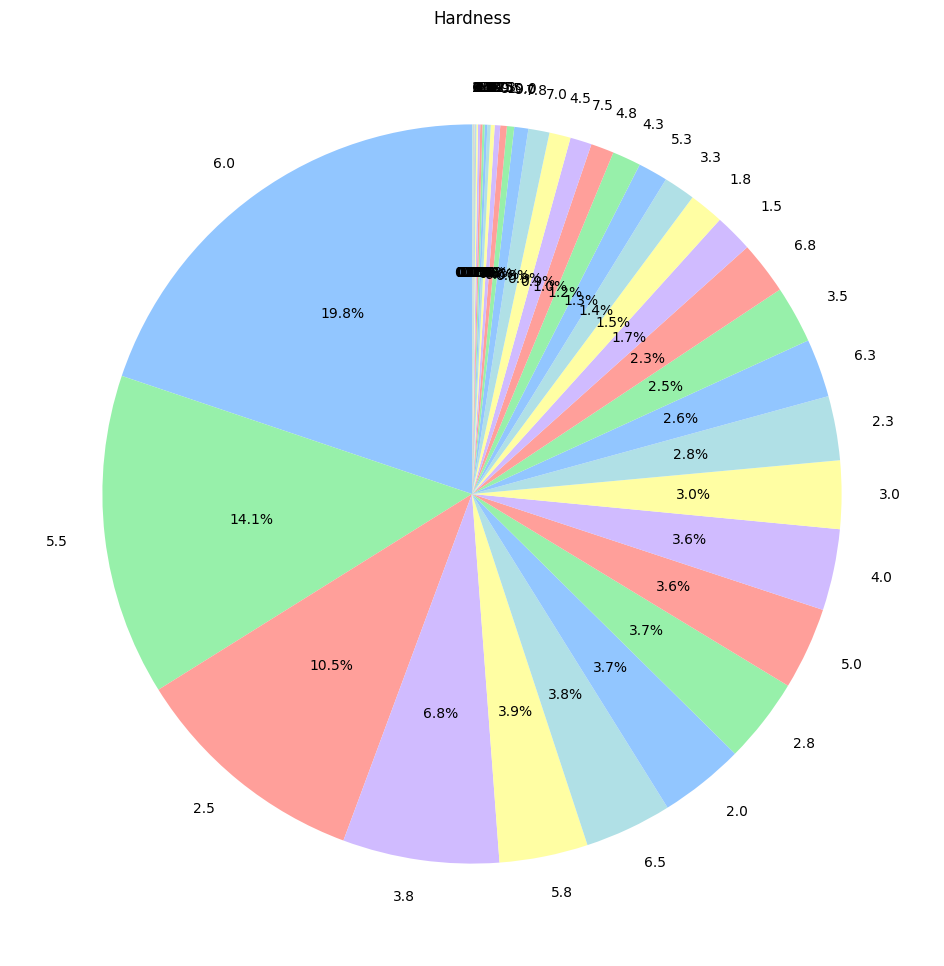

In [31]:
labels = data.Hardness.value_counts()
plt.style.use('seaborn-v0_8-pastel')
plt.figure(figsize=(12, 12))
plt.pie(labels, labels=labels.index, autopct='%1.1f%%', startangle=90)
plt.title('Hardness')
plt.show();

Correlation heatmap:

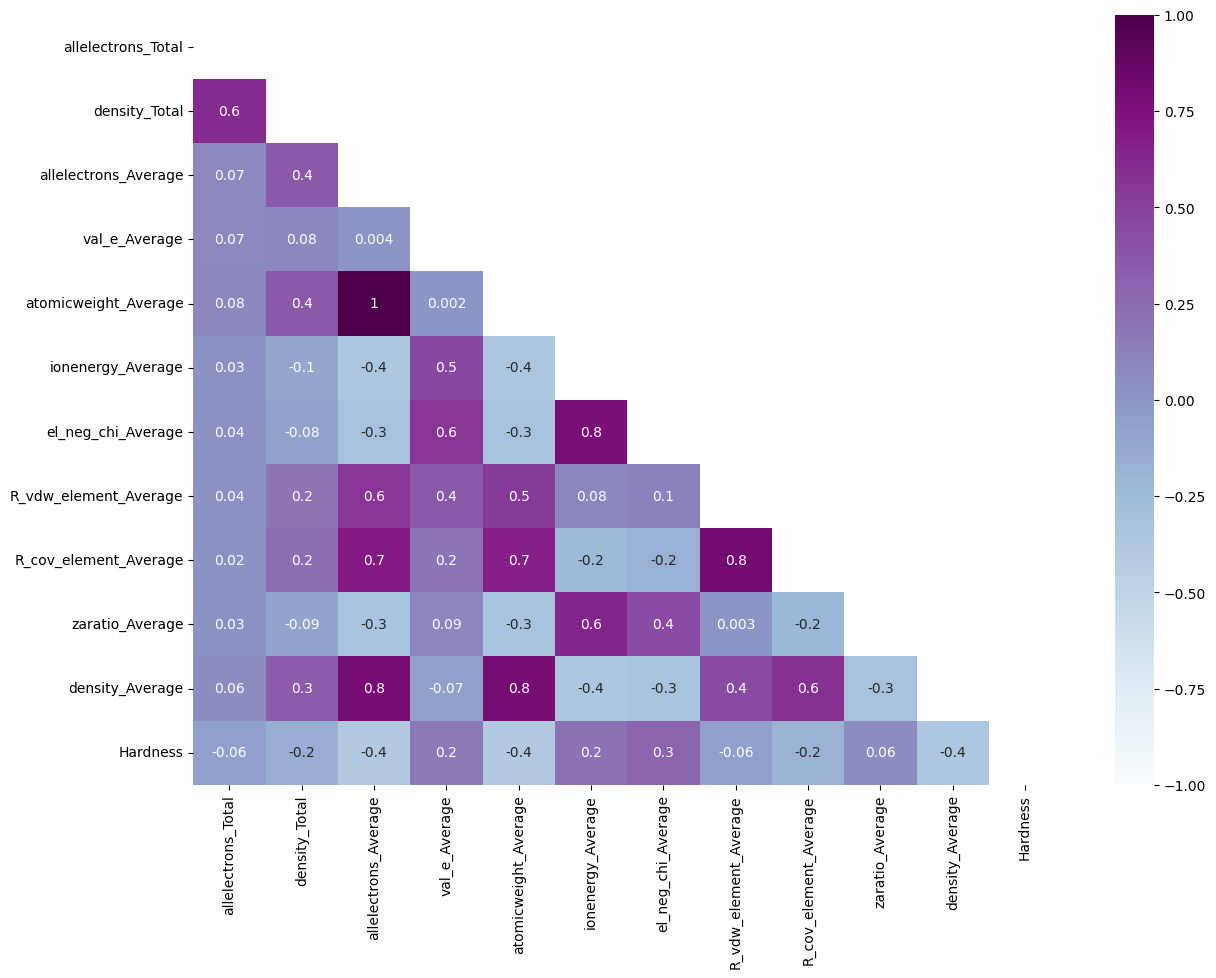

In [32]:
mask = np.triu(np.ones_like(data.corr()))
plt.figure(figsize=(14, 10))
sns.heatmap(data.corr(), cmap="BuPu", annot=True, mask=mask, vmin=-1, vmax=1, fmt=".1g");



*   Correlation of **'atomicweight_Average'** и **'allectrons_Average'** equals 1 which means that these features provide the same information.


*   There is a strong relationship between **'density_Average'** and **'allectrons_Average'**, **'density_Average'** and **'atomicweight_Average'**, **'el_neg_chi_Average'** and **'ionenergy_Average'**, **'R_cov_element_Average'** and **'R_vdw_element_Average'**.



*   There's no strong correlation between features and target.





## Testing models with cross-validation

In [33]:
seed = 42
k = KFold(shuffle = True, random_state = seed)

np.random.seed(seed)
print(k)

KFold(n_splits=5, random_state=42, shuffle=True)


In [34]:
def cross_validation(estimator, cv=k, label=""):
  X = train_df.drop(columns=['Hardness']).copy()
  y = train_df.Hardness

  val_predictions = np.zeros((len(X)))
  train_scores, val_scores = [], []

  for fold, (train_idx, val_idx) in enumerate(cv.split(X)):
    model = clone(estimator)

    #train set
    X_train = X.iloc[train_idx]
    y_train = y.iloc[train_idx]

    #validation set
    X_val = X.iloc[val_idx]
    y_val = y.iloc[val_idx]

    #model training
    model.fit(X_train, y_train)

    #predictions
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_val)
    val_predictions[val_idx] += val_preds

    #evaluation for a fold
    train_score = median_absolute_error(y_train, train_preds)
    val_score = median_absolute_error(y_val, val_preds)

    #append model score to list
    train_scores.append(train_score)
    val_scores.append(val_score)

  print(f'Val score: {np.mean(val_scores):.5f} | Train score: {np.mean(train_scores):.5f} | {label}')

  return val_scores, val_predictions

In [35]:
models = [
    ('xgb', XGBRegressor(random_state = seed, objective = 'reg:absoluteerror')),
    ('lgbm', LGBMRegressor(random_state = seed, verbose = 0, objective = 'mae')),
    ('cb', CatBoostRegressor(random_state = seed, verbose = 0, objective = 'MAE')),
    ('gp', GradientBoostingRegressor(random_state = seed, loss = 'absolute_error')),
    ('hgb', HistGradientBoostingRegressor(random_state = seed, loss = 'absolute_error'))
]

In [ ]:
score_list, val_preds_list = pd.DataFrame(), pd.DataFrame()

for label, model in models:
  score_list[label], val_preds_list[label] = cross_validation(
      model,
      label = label
  )

Val score: 0.55734 | Train score: 0.29069 | xgb
Val score: 0.53798 | Train score: 0.42402 | lgbm
Val score: 0.55313 | Train score: 0.43611 | cb
Val score: 0.59054 | Train score: 0.55174 | gp
Val score: 0.53137 | Train score: 0.42652 | hgb


In [ ]:
score_list

,xgb,lgbm,cb,gp,hgb
0,0.544042,0.523815,0.559171,0.594559,0.525189
1,0.547449,0.513734,0.537108,0.564741,0.525833
2,0.577942,0.565478,0.562249,0.595010,0.537269
3,0.578845,0.560592,0.578153,0.641509,0.550869
4,0.538424,0.526270,0.528956,0.556874,0.517678


## Optuna tuning

In [41]:
X = train_df.drop(columns=['Hardness']).copy()
y = train_df.Hardness

Let's test the values of various parameters:

### XGBRegressor

In [ ]:
def objective(trial):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=seed)
    param = {
        # 'tree_method':'gpu_hist',  # this parameter means using the GPU when training our model to speedup the training process
        # 'sampling_method': 'gradient_based',
        'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
        'alpha': trial.suggest_loguniform('alpha', 7.0, 17.0),
        'eta': trial.suggest_categorical('eta', [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]),
        'gamma': trial.suggest_categorical('gamma', [18, 19, 20, 21, 22, 23, 24, 25]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.01,0.012,0.014,0.016,0.018, 0.02]),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'colsample_bynode': trial.suggest_categorical('colsample_bynode', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'n_estimators': trial.suggest_int('n_estimators', 400, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 8, 600),
        'max_depth': trial.suggest_categorical('max_depth', [3, 4, 5, 6, 7]),
        'subsample': trial.suggest_categorical('subsample', [0.5,0.6,0.7,0.8,1.0])
    }

    model = XGBRegressor(**param, random_state=seed)
    model.fit(X_train, y_train)

    predict = model.predict(X_test)

    mae = median_absolute_error(predict, y_test)

    return mae

In [ ]:
%%time

study = optuna.create_study(direction='minimize', sampler=optuna.samplers.RandomSampler(), pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=100, n_jobs=-1, show_progress_bar=True)
print(f'Number of trials: {len(study.trials)}')
print(f'Best trial: {study.best_trial.params}')

[I 2023-11-25 09:50:18,102] A new study created in memory with name: no-name-998fd46c-79b1-4404-bdcf-46d175bdd05e


  0%|          | 0/100 [00:00<?, ?it/s]

<ipython-input-38-5afb2f61591d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 7.0, 17.0),


[I 2023-11-25 09:50:19,056] Trial 0 finished with value: 0.7829631328582765 and parameters: {'lambda': 9.86453984572848, 'alpha': 8.21342239559571, 'eta': 0.4, 'gamma': 23, 'learning_rate': 0.018, 'colsample_bytree': 0.8, 'colsample_bynode': 0.3, 'n_estimators': 654, 'min_child_weight': 557, 'max_depth': 7, 'subsample': 0.5}. Best is trial 0 with value: 0.7829631328582765.


<ipython-input-38-5afb2f61591d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 7.0, 17.0),


[I 2023-11-25 09:50:19,989] Trial 1 finished with value: 0.7440028190612793 and parameters: {'lambda': 8.141133513028883, 'alpha': 15.367369158240885, 'eta': 0.9, 'gamma': 24, 'learning_rate': 0.018, 'colsample_bytree': 1.0, 'colsample_bynode': 0.8, 'n_estimators': 861, 'min_child_weight': 204, 'max_depth': 3, 'subsample': 0.7}. Best is trial 1 with value: 0.7440028190612793.


<ipython-input-38-5afb2f61591d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 7.0, 17.0),


[I 2023-11-25 09:50:21,106] Trial 2 finished with value: 0.7452173233032227 and parameters: {'lambda': 10.872251497360756, 'alpha': 13.720988812390651, 'eta': 0.6, 'gamma': 25, 'learning_rate': 0.016, 'colsample_bytree': 0.8, 'colsample_bynode': 0.9, 'n_estimators': 932, 'min_child_weight': 293, 'max_depth': 4, 'subsample': 0.8}. Best is trial 1 with value: 0.7440028190612793.


<ipython-input-38-5afb2f61591d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 7.0, 17.0),


[I 2023-11-25 09:50:21,984] Trial 3 finished with value: 0.7585068702697755 and parameters: {'lambda': 7.844112959875584, 'alpha': 9.03492226008727, 'eta': 0.8, 'gamma': 18, 'learning_rate': 0.008, 'colsample_bytree': 0.3, 'colsample_bynode': 1.0, 'n_estimators': 812, 'min_child_weight': 439, 'max_depth': 6, 'subsample': 0.5}. Best is trial 1 with value: 0.7440028190612793.


<ipython-input-38-5afb2f61591d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 7.0, 17.0),


[I 2023-11-25 09:50:22,414] Trial 4 finished with value: 0.7436714172363281 and parameters: {'lambda': 15.753372154296429, 'alpha': 10.267355947435822, 'eta': 0.4, 'gamma': 22, 'learning_rate': 0.014, 'colsample_bytree': 0.5, 'colsample_bynode': 0.9, 'n_estimators': 403, 'min_child_weight': 400, 'max_depth': 3, 'subsample': 0.8}. Best is trial 4 with value: 0.7436714172363281.


<ipython-input-38-5afb2f61591d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 7.0, 17.0),


[I 2023-11-25 09:50:23,560] Trial 6 finished with value: 0.7612055778503417 and parameters: {'lambda': 10.567894093609596, 'alpha': 7.509621963276573, 'eta': 0.8, 'gamma': 18, 'learning_rate': 0.014, 'colsample_bytree': 0.3, 'colsample_bynode': 0.4, 'n_estimators': 458, 'min_child_weight': 42, 'max_depth': 3, 'subsample': 1.0}. Best is trial 4 with value: 0.7436714172363281.


<ipython-input-38-5afb2f61591d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 7.0, 17.0),


[I 2023-11-25 09:50:23,852] Trial 5 finished with value: 0.7722885608673096 and parameters: {'lambda': 10.473641987160134, 'alpha': 8.478258855184762, 'eta': 0.5, 'gamma': 25, 'learning_rate': 0.016, 'colsample_bytree': 0.4, 'colsample_bynode': 0.8, 'n_estimators': 914, 'min_child_weight': 516, 'max_depth': 5, 'subsample': 0.5}. Best is trial 4 with value: 0.7436714172363281.


<ipython-input-38-5afb2f61591d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 7.0, 17.0),


[I 2023-11-25 09:50:25,199] Trial 7 finished with value: 0.7420668601989746 and parameters: {'lambda': 13.907702718750429, 'alpha': 13.543209934277678, 'eta': 0.8, 'gamma': 24, 'learning_rate': 0.012, 'colsample_bytree': 0.3, 'colsample_bynode': 1.0, 'n_estimators': 630, 'min_child_weight': 249, 'max_depth': 3, 'subsample': 0.6}. Best is trial 7 with value: 0.7420668601989746.


<ipython-input-38-5afb2f61591d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 7.0, 17.0),


[I 2023-11-25 09:50:25,758] Trial 8 finished with value: 0.7396678924560547 and parameters: {'lambda': 16.221810475918552, 'alpha': 10.074267997193013, 'eta': 0.9, 'gamma': 25, 'learning_rate': 0.008, 'colsample_bytree': 1.0, 'colsample_bynode': 0.8, 'n_estimators': 707, 'min_child_weight': 285, 'max_depth': 3, 'subsample': 0.8}. Best is trial 8 with value: 0.7396678924560547.


<ipython-input-38-5afb2f61591d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 7.0, 17.0),


[I 2023-11-25 09:50:26,629] Trial 9 finished with value: 0.7604575157165527 and parameters: {'lambda': 15.503893663879406, 'alpha': 15.67434405183813, 'eta': 0.6, 'gamma': 24, 'learning_rate': 0.012, 'colsample_bytree': 1.0, 'colsample_bynode': 1.0, 'n_estimators': 606, 'min_child_weight': 477, 'max_depth': 3, 'subsample': 0.7}. Best is trial 8 with value: 0.7396678924560547.


<ipython-input-38-5afb2f61591d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 7.0, 17.0),


[I 2023-11-25 09:50:27,119] Trial 10 finished with value: 0.7792958259582519 and parameters: {'lambda': 8.112901122978451, 'alpha': 11.846330628442079, 'eta': 0.4, 'gamma': 20, 'learning_rate': 0.008, 'colsample_bytree': 0.7, 'colsample_bynode': 0.7, 'n_estimators': 656, 'min_child_weight': 462, 'max_depth': 7, 'subsample': 0.5}. Best is trial 8 with value: 0.7396678924560547.


<ipython-input-38-5afb2f61591d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 7.0, 17.0),


[I 2023-11-25 09:50:27,682] Trial 11 finished with value: 0.7481276035308837 and parameters: {'lambda': 7.664410262706921, 'alpha': 12.786876582185762, 'eta': 0.7, 'gamma': 23, 'learning_rate': 0.016, 'colsample_bytree': 1.0, 'colsample_bynode': 0.8, 'n_estimators': 872, 'min_child_weight': 437, 'max_depth': 6, 'subsample': 1.0}. Best is trial 8 with value: 0.7396678924560547.


<ipython-input-38-5afb2f61591d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 7.0, 17.0),


[I 2023-11-25 09:50:28,279] Trial 12 finished with value: 0.7470700740814209 and parameters: {'lambda': 14.1478231424597, 'alpha': 8.04963906462292, 'eta': 0.6, 'gamma': 21, 'learning_rate': 0.008, 'colsample_bytree': 1.0, 'colsample_bynode': 0.4, 'n_estimators': 588, 'min_child_weight': 211, 'max_depth': 5, 'subsample': 0.8}. Best is trial 8 with value: 0.7396678924560547.


<ipython-input-38-5afb2f61591d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 7.0, 17.0),


[I 2023-11-25 09:50:28,668] Trial 13 finished with value: 0.7411098480224609 and parameters: {'lambda': 9.2505225481056, 'alpha': 15.917274068449762, 'eta': 0.4, 'gamma': 21, 'learning_rate': 0.018, 'colsample_bytree': 0.8, 'colsample_bynode': 0.7, 'n_estimators': 687, 'min_child_weight': 33, 'max_depth': 6, 'subsample': 0.7}. Best is trial 8 with value: 0.7396678924560547.


<ipython-input-38-5afb2f61591d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 7.0, 17.0),


[I 2023-11-25 09:50:29,109] Trial 14 finished with value: 0.7855839729309082 and parameters: {'lambda': 12.049469741076885, 'alpha': 10.026739966404525, 'eta': 0.7, 'gamma': 18, 'learning_rate': 0.01, 'colsample_bytree': 0.4, 'colsample_bynode': 0.9, 'n_estimators': 459, 'min_child_weight': 433, 'max_depth': 5, 'subsample': 0.5}. Best is trial 8 with value: 0.7396678924560547.


<ipython-input-38-5afb2f61591d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 7.0, 17.0),


[I 2023-11-25 09:50:29,862] Trial 15 finished with value: 0.7412056922912598 and parameters: {'lambda': 9.639484407763732, 'alpha': 11.899607339029032, 'eta': 0.7, 'gamma': 23, 'learning_rate': 0.01, 'colsample_bytree': 1.0, 'colsample_bynode': 0.9, 'n_estimators': 616, 'min_child_weight': 180, 'max_depth': 6, 'subsample': 0.7}. Best is trial 8 with value: 0.7396678924560547.


<ipython-input-38-5afb2f61591d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 7.0, 17.0),


[I 2023-11-25 09:50:30,252] Trial 16 finished with value: 0.7633548736572267 and parameters: {'lambda': 8.543591138906441, 'alpha': 15.092514723996635, 'eta': 0.5, 'gamma': 19, 'learning_rate': 0.016, 'colsample_bytree': 0.8, 'colsample_bynode': 0.7, 'n_estimators': 843, 'min_child_weight': 401, 'max_depth': 5, 'subsample': 0.6}. Best is trial 8 with value: 0.7396678924560547.


<ipython-input-38-5afb2f61591d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 7.0, 17.0),


[I 2023-11-25 09:50:30,980] Trial 17 finished with value: 0.7329951286315919 and parameters: {'lambda': 11.987721343982304, 'alpha': 7.868001855924557, 'eta': 1.0, 'gamma': 20, 'learning_rate': 0.012, 'colsample_bytree': 0.6, 'colsample_bynode': 0.7, 'n_estimators': 791, 'min_child_weight': 259, 'max_depth': 5, 'subsample': 0.6}. Best is trial 17 with value: 0.7329951286315919.


<ipython-input-38-5afb2f61591d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 7.0, 17.0),


[I 2023-11-25 09:50:31,427] Trial 18 finished with value: 0.7745494604110719 and parameters: {'lambda': 11.782587205496503, 'alpha': 11.470298540036767, 'eta': 0.7, 'gamma': 21, 'learning_rate': 0.018, 'colsample_bytree': 0.8, 'colsample_bynode': 0.7, 'n_estimators': 969, 'min_child_weight': 578, 'max_depth': 5, 'subsample': 0.7}. Best is trial 17 with value: 0.7329951286315919.


<ipython-input-38-5afb2f61591d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 7.0, 17.0),


[I 2023-11-25 09:50:31,749] Trial 19 finished with value: 0.7902816772460937 and parameters: {'lambda': 12.674787234725322, 'alpha': 7.067148736525074, 'eta': 0.6, 'gamma': 23, 'learning_rate': 0.01, 'colsample_bytree': 0.3, 'colsample_bynode': 0.4, 'n_estimators': 465, 'min_child_weight': 193, 'max_depth': 4, 'subsample': 0.7}. Best is trial 17 with value: 0.7329951286315919.


<ipython-input-38-5afb2f61591d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 7.0, 17.0),


[I 2023-11-25 09:50:32,409] Trial 20 finished with value: 0.7409912109375001 and parameters: {'lambda': 7.894030827880966, 'alpha': 12.956086838555862, 'eta': 0.3, 'gamma': 21, 'learning_rate': 0.01, 'colsample_bytree': 0.4, 'colsample_bynode': 0.5, 'n_estimators': 746, 'min_child_weight': 219, 'max_depth': 3, 'subsample': 0.6}. Best is trial 17 with value: 0.7329951286315919.


<ipython-input-38-5afb2f61591d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This 

[I 2023-11-25 09:50:33,051] Trial 21 finished with value: 0.7489672899246216 and parameters: {'lambda': 8.24177639857658, 'alpha': 8.572725493174206, 'eta': 0.3, 'gamma': 19, 'learning_rate': 0.008, 'colsample_bytree': 0.7, 'colsample_bynode': 0.8, 'n_estimators': 792, 'min_child_weight': 328, 'max_depth': 6, 'subsample': 1.0}. Best is trial 17 with value: 0.7329951286315919.
[I 2023-11-25 09:50:33,137] Trial 22 finished with value: 0.7700177192687989 and parameters: {'lambda': 8.10364054500878, 'alpha': 8.684211367586052, 'eta': 0.6, 'gamma': 24, 'learning_rate': 0.014, 'colsample_bytree': 0.3, 'colsample_bynode': 0.6, 'n_estimators': 530, 'min_child_weight': 125, 'max_depth': 3, 'subsample': 0.6}. Best is trial 17 with value: 0.7329951286315919.


<ipython-input-38-5afb2f61591d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 7.0, 17.0),


[I 2023-11-25 09:50:34,010] Trial 24 finished with value: 0.7528274059295654 and parameters: {'lambda': 8.921884009306561, 'alpha': 13.21313227713165, 'eta': 0.7, 'gamma': 25, 'learning_rate': 0.016, 'colsample_bytree': 0.4, 'colsample_bynode': 0.6, 'n_estimators': 657, 'min_child_weight': 9, 'max_depth': 4, 'subsample': 0.5}. Best is trial 17 with value: 0.7329951286315919.


<ipython-input-38-5afb2f61591d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 7.0, 17.0),


[I 2023-11-25 09:50:34,224] Trial 23 finished with value: 0.7317725181579591 and parameters: {'lambda': 7.99095855626182, 'alpha': 7.778242269651598, 'eta': 0.4, 'gamma': 18, 'learning_rate': 0.016, 'colsample_bytree': 0.6, 'colsample_bynode': 1.0, 'n_estimators': 865, 'min_child_weight': 296, 'max_depth': 5, 'subsample': 0.7}. Best is trial 23 with value: 0.7317725181579591.


<ipython-input-38-5afb2f61591d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This 

[I 2023-11-25 09:50:34,977] Trial 25 finished with value: 0.7476145029067993 and parameters: {'lambda': 15.507672734901274, 'alpha': 10.766165752061527, 'eta': 0.3, 'gamma': 25, 'learning_rate': 0.01, 'colsample_bytree': 0.5, 'colsample_bynode': 0.5, 'n_estimators': 607, 'min_child_weight': 246, 'max_depth': 4, 'subsample': 0.8}. Best is trial 23 with value: 0.7317725181579591.
[I 2023-11-25 09:50:35,006] Trial 26 finished with value: 0.7458304405212401 and parameters: {'lambda': 14.726079164724004, 'alpha': 11.384146211354597, 'eta': 0.8, 'gamma': 22, 'learning_rate': 0.02, 'colsample_bytree': 0.4, 'colsample_bynode': 0.7, 'n_estimators': 568, 'min_child_weight': 84, 'max_depth': 5, 'subsample': 0.7}. Best is trial 23 with value: 0.7317725181579591.


<ipython-input-38-5afb2f61591d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 7.0, 17.0),


[I 2023-11-25 09:50:35,664] Trial 27 finished with value: 0.7389082908630371 and parameters: {'lambda': 7.434925644105407, 'alpha': 14.695038638134212, 'eta': 1.0, 'gamma': 23, 'learning_rate': 0.018, 'colsample_bytree': 0.9, 'colsample_bynode': 0.8, 'n_estimators': 447, 'min_child_weight': 117, 'max_depth': 4, 'subsample': 0.7}. Best is trial 23 with value: 0.7317725181579591.
[I 2023-11-25 09:50:35,779] Trial 28 finished with value: 0.7481895446777345 and parameters: {'lambda': 11.962056120644599, 'alpha': 12.406213866518689, 'eta': 0.4, 'gamma': 22, 'learning_rate': 0.012, 'colsample_bytree': 0.8, 'colsample_bynode': 0.3, 'n_estimators': 513, 'min_child_weight': 251, 'max_depth': 3, 'subsample': 0.7}. Best is trial 23 with value: 0.7317725181579591.


<ipython-input-38-5afb2f61591d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This 

[I 2023-11-25 09:50:37,031] Trial 29 finished with value: 0.739471435546875 and parameters: {'lambda': 7.709334268136235, 'alpha': 9.268510021409176, 'eta': 1.0, 'gamma': 23, 'learning_rate': 0.01, 'colsample_bytree': 0.8, 'colsample_bynode': 0.9, 'n_estimators': 448, 'min_child_weight': 150, 'max_depth': 5, 'subsample': 0.8}. Best is trial 23 with value: 0.7317725181579591.
[I 2023-11-25 09:50:37,118] Trial 30 finished with value: 0.7526452541351318 and parameters: {'lambda': 10.16536533517393, 'alpha': 7.701966386384886, 'eta': 1.0, 'gamma': 23, 'learning_rate': 0.01, 'colsample_bytree': 0.9, 'colsample_bynode': 0.3, 'n_estimators': 904, 'min_child_weight': 284, 'max_depth': 4, 'subsample': 1.0}. Best is trial 23 with value: 0.7317725181579591.


<ipython-input-38-5afb2f61591d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This 

[I 2023-11-25 09:50:38,529] Trial 32 finished with value: 0.7689533233642578 and parameters: {'lambda': 11.403988888726225, 'alpha': 14.425989527286957, 'eta': 1.0, 'gamma': 24, 'learning_rate': 0.016, 'colsample_bytree': 0.7, 'colsample_bynode': 0.7, 'n_estimators': 501, 'min_child_weight': 416, 'max_depth': 5, 'subsample': 0.6}. Best is trial 23 with value: 0.7317725181579591.
[I 2023-11-25 09:50:38,655] Trial 31 finished with value: 0.7484619617462158 and parameters: {'lambda': 16.47619279459558, 'alpha': 10.314097399541911, 'eta': 0.6, 'gamma': 22, 'learning_rate': 0.012, 'colsample_bytree': 0.7, 'colsample_bynode': 0.6, 'n_estimators': 630, 'min_child_weight': 413, 'max_depth': 5, 'subsample': 1.0}. Best is trial 23 with value: 0.7317725181579591.


<ipython-input-38-5afb2f61591d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This 

[I 2023-11-25 09:50:40,397] Trial 34 finished with value: 0.7493298053741455 and parameters: {'lambda': 11.260165961075023, 'alpha': 14.80008451890868, 'eta': 0.8, 'gamma': 22, 'learning_rate': 0.014, 'colsample_bytree': 1.0, 'colsample_bynode': 0.9, 'n_estimators': 614, 'min_child_weight': 234, 'max_depth': 6, 'subsample': 0.8}. Best is trial 23 with value: 0.7317725181579591.
[I 2023-11-25 09:50:40,517] Trial 33 finished with value: 0.7411785125732422 and parameters: {'lambda': 9.176242907455372, 'alpha': 13.547538209540988, 'eta': 0.6, 'gamma': 20, 'learning_rate': 0.02, 'colsample_bytree': 0.7, 'colsample_bynode': 0.8, 'n_estimators': 908, 'min_child_weight': 317, 'max_depth': 5, 'subsample': 0.6}. Best is trial 23 with value: 0.7317725181579591.


<ipython-input-38-5afb2f61591d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 7.0, 17.0),


[I 2023-11-25 09:50:41,731] Trial 35 finished with value: 0.7516104221343993 and parameters: {'lambda': 10.304643528239046, 'alpha': 13.98818980266963, 'eta': 0.4, 'gamma': 25, 'learning_rate': 0.016, 'colsample_bytree': 1.0, 'colsample_bynode': 0.3, 'n_estimators': 655, 'min_child_weight': 351, 'max_depth': 4, 'subsample': 1.0}. Best is trial 23 with value: 0.7317725181579591.


<ipython-input-38-5afb2f61591d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 7.0, 17.0),


[I 2023-11-25 09:50:42,467] Trial 36 finished with value: 0.7955996990203857 and parameters: {'lambda': 9.59246577999679, 'alpha': 7.086180486484609, 'eta': 0.4, 'gamma': 19, 'learning_rate': 0.008, 'colsample_bytree': 0.3, 'colsample_bynode': 0.6, 'n_estimators': 690, 'min_child_weight': 526, 'max_depth': 4, 'subsample': 0.8}. Best is trial 23 with value: 0.7317725181579591.


<ipython-input-38-5afb2f61591d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 7.0, 17.0),


[I 2023-11-25 09:50:43,070] Trial 37 finished with value: 0.7538220882415771 and parameters: {'lambda': 10.194768043331466, 'alpha': 9.114568786328517, 'eta': 0.5, 'gamma': 21, 'learning_rate': 0.014, 'colsample_bytree': 1.0, 'colsample_bynode': 1.0, 'n_estimators': 453, 'min_child_weight': 316, 'max_depth': 3, 'subsample': 0.5}. Best is trial 23 with value: 0.7317725181579591.


<ipython-input-38-5afb2f61591d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 7.0, 17.0),


[I 2023-11-25 09:50:43,889] Trial 38 finished with value: 0.748852014541626 and parameters: {'lambda': 7.3526417264315915, 'alpha': 11.623938173746614, 'eta': 0.8, 'gamma': 22, 'learning_rate': 0.02, 'colsample_bytree': 0.4, 'colsample_bynode': 0.5, 'n_estimators': 611, 'min_child_weight': 457, 'max_depth': 7, 'subsample': 0.7}. Best is trial 23 with value: 0.7317725181579591.


<ipython-input-38-5afb2f61591d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This 

[I 2023-11-25 09:50:44,781] Trial 39 finished with value: 0.7531142234802246 and parameters: {'lambda': 15.605161940244543, 'alpha': 9.72815590718676, 'eta': 0.3, 'gamma': 23, 'learning_rate': 0.01, 'colsample_bytree': 0.6, 'colsample_bynode': 1.0, 'n_estimators': 852, 'min_child_weight': 259, 'max_depth': 6, 'subsample': 0.5}. Best is trial 23 with value: 0.7317725181579591.
[I 2023-11-25 09:50:44,953] Trial 40 finished with value: 0.7395282268524168 and parameters: {'lambda': 7.090803621427024, 'alpha': 11.388755812278045, 'eta': 0.6, 'gamma': 22, 'learning_rate': 0.02, 'colsample_bytree': 0.4, 'colsample_bynode': 0.5, 'n_estimators': 822, 'min_child_weight': 140, 'max_depth': 7, 'subsample': 0.6}. Best is trial 23 with value: 0.7317725181579591.


<ipython-input-38-5afb2f61591d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 7.0, 17.0),


[I 2023-11-25 09:50:46,122] Trial 41 finished with value: 0.7472450733184814 and parameters: {'lambda': 15.615283597810194, 'alpha': 8.547272734149288, 'eta': 0.8, 'gamma': 24, 'learning_rate': 0.008, 'colsample_bytree': 0.9, 'colsample_bynode': 0.6, 'n_estimators': 730, 'min_child_weight': 192, 'max_depth': 7, 'subsample': 0.7}. Best is trial 23 with value: 0.7317725181579591.
[I 2023-11-25 09:50:46,131] Trial 42 finished with value: 0.7537153720855714 and parameters: {'lambda': 7.725754894961515, 'alpha': 9.070610654780149, 'eta': 0.6, 'gamma': 22, 'learning_rate': 0.012, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'n_estimators': 817, 'min_child_weight': 374, 'max_depth': 5, 'subsample': 0.8}. Best is trial 23 with value: 0.7317725181579591.


<ipython-input-38-5afb2f61591d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 7.0, 17.0),


[I 2023-11-25 09:50:46,934] Trial 43 finished with value: 0.7437882423400879 and parameters: {'lambda': 12.499814809402512, 'alpha': 12.671215765195901, 'eta': 0.4, 'gamma': 19, 'learning_rate': 0.008, 'colsample_bytree': 0.8, 'colsample_bynode': 0.4, 'n_estimators': 525, 'min_child_weight': 449, 'max_depth': 3, 'subsample': 1.0}. Best is trial 23 with value: 0.7317725181579591.


<ipython-input-38-5afb2f61591d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 7.0, 17.0),


[I 2023-11-25 09:50:47,493] Trial 44 finished with value: 0.7356095314025879 and parameters: {'lambda': 7.544432307593315, 'alpha': 9.107056997156699, 'eta': 0.5, 'gamma': 20, 'learning_rate': 0.008, 'colsample_bytree': 0.7, 'colsample_bynode': 0.6, 'n_estimators': 981, 'min_child_weight': 172, 'max_depth': 3, 'subsample': 0.7}. Best is trial 23 with value: 0.7317725181579591.


<ipython-input-38-5afb2f61591d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 7.0, 17.0),


[I 2023-11-25 09:50:48,206] Trial 45 finished with value: 0.763152575492859 and parameters: {'lambda': 15.919163343527426, 'alpha': 7.183325254076134, 'eta': 0.7, 'gamma': 19, 'learning_rate': 0.01, 'colsample_bytree': 0.4, 'colsample_bynode': 0.7, 'n_estimators': 961, 'min_child_weight': 291, 'max_depth': 5, 'subsample': 0.5}. Best is trial 23 with value: 0.7317725181579591.


<ipython-input-38-5afb2f61591d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 7.0, 17.0),


[I 2023-11-25 09:50:48,742] Trial 46 finished with value: 0.7479520797729493 and parameters: {'lambda': 12.094645594375624, 'alpha': 16.61136007803647, 'eta': 0.7, 'gamma': 22, 'learning_rate': 0.008, 'colsample_bytree': 1.0, 'colsample_bynode': 0.5, 'n_estimators': 619, 'min_child_weight': 294, 'max_depth': 5, 'subsample': 0.7}. Best is trial 23 with value: 0.7317725181579591.


<ipython-input-38-5afb2f61591d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 7.0, 17.0),


[I 2023-11-25 09:50:49,078] Trial 47 finished with value: 0.783144474029541 and parameters: {'lambda': 8.74817527897014, 'alpha': 10.147102076124488, 'eta': 0.4, 'gamma': 18, 'learning_rate': 0.01, 'colsample_bytree': 0.4, 'colsample_bynode': 0.4, 'n_estimators': 588, 'min_child_weight': 456, 'max_depth': 4, 'subsample': 1.0}. Best is trial 23 with value: 0.7317725181579591.


<ipython-input-38-5afb2f61591d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 7.0, 17.0),


[I 2023-11-25 09:50:49,465] Trial 48 finished with value: 0.7512600421905518 and parameters: {'lambda': 7.880304947729449, 'alpha': 14.306327598269121, 'eta': 0.6, 'gamma': 21, 'learning_rate': 0.018, 'colsample_bytree': 0.7, 'colsample_bynode': 1.0, 'n_estimators': 423, 'min_child_weight': 335, 'max_depth': 5, 'subsample': 0.7}. Best is trial 23 with value: 0.7317725181579591.


<ipython-input-38-5afb2f61591d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 7.0, 17.0),


[I 2023-11-25 09:50:49,866] Trial 49 finished with value: 0.7849479913711548 and parameters: {'lambda': 13.09828999808731, 'alpha': 14.138223621685254, 'eta': 0.5, 'gamma': 18, 'learning_rate': 0.016, 'colsample_bytree': 0.3, 'colsample_bynode': 0.4, 'n_estimators': 536, 'min_child_weight': 531, 'max_depth': 7, 'subsample': 0.7}. Best is trial 23 with value: 0.7317725181579591.


<ipython-input-38-5afb2f61591d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 7.0, 17.0),


[I 2023-11-25 09:50:50,495] Trial 50 finished with value: 0.7397769689559937 and parameters: {'lambda': 15.379378962970948, 'alpha': 13.520682837288104, 'eta': 0.7, 'gamma': 21, 'learning_rate': 0.016, 'colsample_bytree': 0.7, 'colsample_bynode': 0.7, 'n_estimators': 911, 'min_child_weight': 449, 'max_depth': 5, 'subsample': 1.0}. Best is trial 23 with value: 0.7317725181579591.


<ipython-input-38-5afb2f61591d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 7.0, 17.0),


[I 2023-11-25 09:50:50,741] Trial 51 finished with value: 0.749219536781311 and parameters: {'lambda': 15.709995928999696, 'alpha': 13.853000932083674, 'eta': 0.8, 'gamma': 18, 'learning_rate': 0.018, 'colsample_bytree': 0.3, 'colsample_bynode': 0.7, 'n_estimators': 599, 'min_child_weight': 68, 'max_depth': 5, 'subsample': 0.6}. Best is trial 23 with value: 0.7317725181579591.


<ipython-input-38-5afb2f61591d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 7.0, 17.0),


[I 2023-11-25 09:50:51,407] Trial 52 finished with value: 0.7326409816741943 and parameters: {'lambda': 7.9251710350546025, 'alpha': 12.523012170175472, 'eta': 0.3, 'gamma': 18, 'learning_rate': 0.014, 'colsample_bytree': 0.6, 'colsample_bynode': 0.6, 'n_estimators': 532, 'min_child_weight': 32, 'max_depth': 5, 'subsample': 0.7}. Best is trial 23 with value: 0.7317725181579591.


<ipython-input-38-5afb2f61591d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 7.0, 17.0),


[I 2023-11-25 09:50:51,786] Trial 53 finished with value: 0.7377520799636841 and parameters: {'lambda': 13.826424428429581, 'alpha': 12.762667349155578, 'eta': 0.5, 'gamma': 23, 'learning_rate': 0.014, 'colsample_bytree': 0.6, 'colsample_bynode': 0.7, 'n_estimators': 930, 'min_child_weight': 193, 'max_depth': 3, 'subsample': 0.8}. Best is trial 23 with value: 0.7317725181579591.


<ipython-input-38-5afb2f61591d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 7.0, 17.0),


[I 2023-11-25 09:50:52,225] Trial 54 finished with value: 0.7585573196411133 and parameters: {'lambda': 9.288301538137338, 'alpha': 14.587631850492636, 'eta': 0.8, 'gamma': 20, 'learning_rate': 0.02, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'n_estimators': 543, 'min_child_weight': 479, 'max_depth': 5, 'subsample': 0.8}. Best is trial 23 with value: 0.7317725181579591.


<ipython-input-38-5afb2f61591d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This 

[I 2023-11-25 09:50:53,182] Trial 55 finished with value: 0.7708613872528076 and parameters: {'lambda': 7.791751572004583, 'alpha': 7.953659312566278, 'eta': 0.8, 'gamma': 21, 'learning_rate': 0.01, 'colsample_bytree': 1.0, 'colsample_bynode': 0.9, 'n_estimators': 987, 'min_child_weight': 580, 'max_depth': 4, 'subsample': 0.5}. Best is trial 23 with value: 0.7317725181579591.
[I 2023-11-25 09:50:53,348] Trial 56 finished with value: 0.7751580476760864 and parameters: {'lambda': 7.958263106550662, 'alpha': 16.95928566409885, 'eta': 0.7, 'gamma': 25, 'learning_rate': 0.014, 'colsample_bytree': 0.9, 'colsample_bynode': 0.9, 'n_estimators': 865, 'min_child_weight': 482, 'max_depth': 6, 'subsample': 0.5}. Best is trial 23 with value: 0.7317725181579591.


<ipython-input-38-5afb2f61591d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 7.0, 17.0),


[I 2023-11-25 09:50:54,344] Trial 57 finished with value: 0.7280535697937012 and parameters: {'lambda': 8.38522665747767, 'alpha': 7.161115873050603, 'eta': 0.6, 'gamma': 20, 'learning_rate': 0.018, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'n_estimators': 817, 'min_child_weight': 321, 'max_depth': 3, 'subsample': 0.7}. Best is trial 57 with value: 0.7280535697937012.


<ipython-input-38-5afb2f61591d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 7.0, 17.0),


[I 2023-11-25 09:50:54,562] Trial 58 finished with value: 0.7358052492141725 and parameters: {'lambda': 9.41055422376758, 'alpha': 9.109812545071605, 'eta': 0.9, 'gamma': 22, 'learning_rate': 0.02, 'colsample_bytree': 1.0, 'colsample_bynode': 0.8, 'n_estimators': 749, 'min_child_weight': 244, 'max_depth': 5, 'subsample': 0.6}. Best is trial 57 with value: 0.7280535697937012.


<ipython-input-38-5afb2f61591d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 7.0, 17.0),


[I 2023-11-25 09:50:56,427] Trial 59 finished with value: 0.789268708229065 and parameters: {'lambda': 11.10801726893839, 'alpha': 16.916140538813686, 'eta': 0.7, 'gamma': 22, 'learning_rate': 0.008, 'colsample_bytree': 0.3, 'colsample_bynode': 0.3, 'n_estimators': 977, 'min_child_weight': 445, 'max_depth': 3, 'subsample': 0.7}. Best is trial 57 with value: 0.7280535697937012.


<ipython-input-38-5afb2f61591d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 7.0, 17.0),


[I 2023-11-25 09:50:57,242] Trial 60 finished with value: 0.7615966796875 and parameters: {'lambda': 7.130582855063956, 'alpha': 9.197109376429156, 'eta': 0.8, 'gamma': 19, 'learning_rate': 0.008, 'colsample_bytree': 0.9, 'colsample_bynode': 0.5, 'n_estimators': 913, 'min_child_weight': 373, 'max_depth': 5, 'subsample': 0.6}. Best is trial 57 with value: 0.7280535697937012.


<ipython-input-38-5afb2f61591d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 7.0, 17.0),


[I 2023-11-25 09:50:57,755] Trial 61 finished with value: 0.7304519414901733 and parameters: {'lambda': 12.737298680334932, 'alpha': 11.842825186048081, 'eta': 0.9, 'gamma': 19, 'learning_rate': 0.02, 'colsample_bytree': 1.0, 'colsample_bynode': 0.3, 'n_estimators': 513, 'min_child_weight': 320, 'max_depth': 5, 'subsample': 0.8}. Best is trial 57 with value: 0.7280535697937012.


<ipython-input-38-5afb2f61591d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 7.0, 17.0),


[I 2023-11-25 09:50:58,403] Trial 62 finished with value: 0.7704626321792603 and parameters: {'lambda': 8.126961787917837, 'alpha': 11.914761199134428, 'eta': 0.9, 'gamma': 24, 'learning_rate': 0.02, 'colsample_bytree': 0.7, 'colsample_bynode': 0.3, 'n_estimators': 504, 'min_child_weight': 552, 'max_depth': 3, 'subsample': 0.7}. Best is trial 57 with value: 0.7280535697937012.


<ipython-input-38-5afb2f61591d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 7.0, 17.0),


[I 2023-11-25 09:51:00,360] Trial 63 finished with value: 0.756267786026001 and parameters: {'lambda': 9.748185787292496, 'alpha': 7.702214303970104, 'eta': 1.0, 'gamma': 22, 'learning_rate': 0.008, 'colsample_bytree': 0.8, 'colsample_bynode': 1.0, 'n_estimators': 933, 'min_child_weight': 335, 'max_depth': 6, 'subsample': 1.0}. Best is trial 57 with value: 0.7280535697937012.


<ipython-input-38-5afb2f61591d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 7.0, 17.0),


[I 2023-11-25 09:51:00,822] Trial 64 finished with value: 0.7377447128295898 and parameters: {'lambda': 16.124619871360014, 'alpha': 11.924063415975583, 'eta': 0.6, 'gamma': 24, 'learning_rate': 0.012, 'colsample_bytree': 0.6, 'colsample_bynode': 0.8, 'n_estimators': 983, 'min_child_weight': 56, 'max_depth': 6, 'subsample': 0.8}. Best is trial 57 with value: 0.7280535697937012.


<ipython-input-38-5afb2f61591d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This 

[I 2023-11-25 09:51:02,047] Trial 65 finished with value: 0.7528998851776123 and parameters: {'lambda': 13.070886728846062, 'alpha': 9.432736521109433, 'eta': 0.3, 'gamma': 19, 'learning_rate': 0.014, 'colsample_bytree': 0.7, 'colsample_bynode': 0.7, 'n_estimators': 713, 'min_child_weight': 279, 'max_depth': 5, 'subsample': 0.5}. Best is trial 57 with value: 0.7280535697937012.
[I 2023-11-25 09:51:02,106] Trial 66 finished with value: 0.7588837146759033 and parameters: {'lambda': 7.68783775872195, 'alpha': 11.67477169731495, 'eta': 0.5, 'gamma': 19, 'learning_rate': 0.02, 'colsample_bytree': 0.8, 'colsample_bynode': 0.7, 'n_estimators': 655, 'min_child_weight': 593, 'max_depth': 4, 'subsample': 0.7}. Best is trial 57 with value: 0.7280535697937012.


<ipython-input-38-5afb2f61591d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 7.0, 17.0),


[I 2023-11-25 09:51:02,821] Trial 67 finished with value: 0.7325939178466796 and parameters: {'lambda': 14.164017698116226, 'alpha': 10.722692725854406, 'eta': 0.8, 'gamma': 18, 'learning_rate': 0.018, 'colsample_bytree': 0.7, 'colsample_bynode': 0.4, 'n_estimators': 564, 'min_child_weight': 161, 'max_depth': 7, 'subsample': 1.0}. Best is trial 57 with value: 0.7280535697937012.


<ipython-input-38-5afb2f61591d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 7.0, 17.0),


[I 2023-11-25 09:51:03,066] Trial 68 finished with value: 0.748201036453247 and parameters: {'lambda': 10.153719620340445, 'alpha': 7.291939741578456, 'eta': 0.8, 'gamma': 24, 'learning_rate': 0.01, 'colsample_bytree': 0.7, 'colsample_bynode': 0.3, 'n_estimators': 574, 'min_child_weight': 163, 'max_depth': 7, 'subsample': 1.0}. Best is trial 57 with value: 0.7280535697937012.


<ipython-input-38-5afb2f61591d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 7.0, 17.0),


[I 2023-11-25 09:51:03,836] Trial 69 finished with value: 0.7502057790756225 and parameters: {'lambda': 9.178646749263901, 'alpha': 14.362328471656522, 'eta': 0.8, 'gamma': 25, 'learning_rate': 0.018, 'colsample_bytree': 0.7, 'colsample_bynode': 0.5, 'n_estimators': 898, 'min_child_weight': 103, 'max_depth': 7, 'subsample': 1.0}. Best is trial 57 with value: 0.7280535697937012.


<ipython-input-38-5afb2f61591d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 7.0, 17.0),


[I 2023-11-25 09:51:04,301] Trial 70 finished with value: 0.7607452869415283 and parameters: {'lambda': 11.006787669673619, 'alpha': 11.290605245809601, 'eta': 0.8, 'gamma': 24, 'learning_rate': 0.008, 'colsample_bytree': 0.6, 'colsample_bynode': 0.9, 'n_estimators': 735, 'min_child_weight': 260, 'max_depth': 5, 'subsample': 0.5}. Best is trial 57 with value: 0.7280535697937012.


<ipython-input-38-5afb2f61591d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 7.0, 17.0),


[I 2023-11-25 09:51:05,179] Trial 71 finished with value: 0.749375581741333 and parameters: {'lambda': 13.173311155833087, 'alpha': 7.533554422679528, 'eta': 0.4, 'gamma': 18, 'learning_rate': 0.012, 'colsample_bytree': 0.9, 'colsample_bynode': 0.4, 'n_estimators': 945, 'min_child_weight': 445, 'max_depth': 6, 'subsample': 0.8}. Best is trial 57 with value: 0.7280535697937012.


<ipython-input-38-5afb2f61591d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 7.0, 17.0),


[I 2023-11-25 09:51:05,464] Trial 72 finished with value: 0.7704976558685304 and parameters: {'lambda': 11.148984111294121, 'alpha': 9.900737969951708, 'eta': 1.0, 'gamma': 21, 'learning_rate': 0.008, 'colsample_bytree': 0.6, 'colsample_bynode': 0.7, 'n_estimators': 771, 'min_child_weight': 595, 'max_depth': 4, 'subsample': 0.7}. Best is trial 57 with value: 0.7280535697937012.


<ipython-input-38-5afb2f61591d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This 

[I 2023-11-25 09:51:06,126] Trial 74 finished with value: 0.7430670022964478 and parameters: {'lambda': 8.723729366304955, 'alpha': 12.378761435282843, 'eta': 0.9, 'gamma': 19, 'learning_rate': 0.014, 'colsample_bytree': 0.4, 'colsample_bynode': 0.5, 'n_estimators': 400, 'min_child_weight': 127, 'max_depth': 4, 'subsample': 0.7}. Best is trial 57 with value: 0.7280535697937012.
[I 2023-11-25 09:51:06,194] Trial 73 finished with value: 0.7322100400924683 and parameters: {'lambda': 8.353944167839686, 'alpha': 7.304536843746527, 'eta': 0.7, 'gamma': 18, 'learning_rate': 0.014, 'colsample_bytree': 0.4, 'colsample_bynode': 0.6, 'n_estimators': 683, 'min_child_weight': 166, 'max_depth': 7, 'subsample': 1.0}. Best is trial 57 with value: 0.7280535697937012.


<ipython-input-38-5afb2f61591d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 7.0, 17.0),


[I 2023-11-25 09:51:06,941] Trial 75 finished with value: 0.7622082233428955 and parameters: {'lambda': 10.473701516881135, 'alpha': 13.476538435462253, 'eta': 0.3, 'gamma': 24, 'learning_rate': 0.012, 'colsample_bytree': 1.0, 'colsample_bynode': 1.0, 'n_estimators': 420, 'min_child_weight': 278, 'max_depth': 4, 'subsample': 0.6}. Best is trial 57 with value: 0.7280535697937012.


<ipython-input-38-5afb2f61591d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 7.0, 17.0),


[I 2023-11-25 09:51:07,226] Trial 76 finished with value: 0.7547169923782349 and parameters: {'lambda': 11.157196116863986, 'alpha': 12.87030132617644, 'eta': 0.5, 'gamma': 21, 'learning_rate': 0.018, 'colsample_bytree': 0.6, 'colsample_bynode': 0.8, 'n_estimators': 867, 'min_child_weight': 475, 'max_depth': 4, 'subsample': 0.8}. Best is trial 57 with value: 0.7280535697937012.


<ipython-input-38-5afb2f61591d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 7.0, 17.0),


[I 2023-11-25 09:51:08,070] Trial 78 finished with value: 0.7527265548706055 and parameters: {'lambda': 7.81914676704981, 'alpha': 7.426587729110896, 'eta': 0.9, 'gamma': 21, 'learning_rate': 0.018, 'colsample_bytree': 1.0, 'colsample_bynode': 0.6, 'n_estimators': 672, 'min_child_weight': 491, 'max_depth': 6, 'subsample': 1.0}. Best is trial 57 with value: 0.7280535697937012.


<ipython-input-38-5afb2f61591d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 7.0, 17.0),


[I 2023-11-25 09:51:08,310] Trial 77 finished with value: 0.7584213256835937 and parameters: {'lambda': 15.009565013158559, 'alpha': 15.271169788569313, 'eta': 0.4, 'gamma': 19, 'learning_rate': 0.008, 'colsample_bytree': 0.5, 'colsample_bynode': 0.4, 'n_estimators': 704, 'min_child_weight': 64, 'max_depth': 6, 'subsample': 0.7}. Best is trial 57 with value: 0.7280535697937012.


<ipython-input-38-5afb2f61591d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 7.0, 17.0),


[I 2023-11-25 09:51:09,221] Trial 80 finished with value: 0.7684998273849488 and parameters: {'lambda': 8.702790410279464, 'alpha': 13.069279068410676, 'eta': 0.4, 'gamma': 18, 'learning_rate': 0.018, 'colsample_bytree': 0.9, 'colsample_bynode': 0.4, 'n_estimators': 742, 'min_child_weight': 587, 'max_depth': 4, 'subsample': 0.6}. Best is trial 57 with value: 0.7280535697937012.


<ipython-input-38-5afb2f61591d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This 

[I 2023-11-25 09:51:09,754] Trial 79 finished with value: 0.7367933988571167 and parameters: {'lambda': 13.740774341688965, 'alpha': 7.6485727111957145, 'eta': 0.6, 'gamma': 23, 'learning_rate': 0.008, 'colsample_bytree': 0.9, 'colsample_bynode': 1.0, 'n_estimators': 990, 'min_child_weight': 89, 'max_depth': 6, 'subsample': 1.0}. Best is trial 57 with value: 0.7280535697937012.
[I 2023-11-25 09:51:09,901] Trial 81 finished with value: 0.7550921440124512 and parameters: {'lambda': 10.320767090963427, 'alpha': 8.90920710429239, 'eta': 0.7, 'gamma': 21, 'learning_rate': 0.02, 'colsample_bytree': 0.4, 'colsample_bynode': 0.7, 'n_estimators': 482, 'min_child_weight': 453, 'max_depth': 4, 'subsample': 0.6}. Best is trial 57 with value: 0.7280535697937012.


<ipython-input-38-5afb2f61591d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This 

[I 2023-11-25 09:51:10,612] Trial 82 finished with value: 0.7414913177490234 and parameters: {'lambda': 13.662941967407797, 'alpha': 9.156091183176974, 'eta': 1.0, 'gamma': 25, 'learning_rate': 0.016, 'colsample_bytree': 1.0, 'colsample_bynode': 0.3, 'n_estimators': 614, 'min_child_weight': 315, 'max_depth': 6, 'subsample': 0.8}. Best is trial 57 with value: 0.7280535697937012.
[I 2023-11-25 09:51:10,802] Trial 83 finished with value: 0.7486375808715819 and parameters: {'lambda': 9.184526990551477, 'alpha': 8.092228458668899, 'eta': 0.4, 'gamma': 20, 'learning_rate': 0.014, 'colsample_bytree': 0.9, 'colsample_bynode': 0.9, 'n_estimators': 475, 'min_child_weight': 516, 'max_depth': 7, 'subsample': 1.0}. Best is trial 57 with value: 0.7280535697937012.


<ipython-input-38-5afb2f61591d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 7.0, 17.0),


[I 2023-11-25 09:51:11,729] Trial 84 finished with value: 0.7359417438507081 and parameters: {'lambda': 7.238936451435698, 'alpha': 9.793491296618987, 'eta': 0.6, 'gamma': 21, 'learning_rate': 0.014, 'colsample_bytree': 0.3, 'colsample_bynode': 0.9, 'n_estimators': 864, 'min_child_weight': 273, 'max_depth': 4, 'subsample': 0.8}. Best is trial 57 with value: 0.7280535697937012.


<ipython-input-38-5afb2f61591d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 7.0, 17.0),


[I 2023-11-25 09:51:12,022] Trial 85 finished with value: 0.765805721282959 and parameters: {'lambda': 9.694056861631045, 'alpha': 11.571976599715256, 'eta': 0.8, 'gamma': 22, 'learning_rate': 0.008, 'colsample_bytree': 0.4, 'colsample_bynode': 0.6, 'n_estimators': 747, 'min_child_weight': 379, 'max_depth': 5, 'subsample': 0.7}. Best is trial 57 with value: 0.7280535697937012.


<ipython-input-38-5afb2f61591d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This 

[I 2023-11-25 09:51:13,569] Trial 87 finished with value: 0.7533297538757324 and parameters: {'lambda': 7.485930260567657, 'alpha': 16.82210178228603, 'eta': 0.7, 'gamma': 21, 'learning_rate': 0.016, 'colsample_bytree': 1.0, 'colsample_bynode': 0.5, 'n_estimators': 827, 'min_child_weight': 466, 'max_depth': 3, 'subsample': 0.7}. Best is trial 57 with value: 0.7280535697937012.
[I 2023-11-25 09:51:13,747] Trial 86 finished with value: 0.7409144401550294 and parameters: {'lambda': 13.026311197604107, 'alpha': 10.756031901431818, 'eta': 1.0, 'gamma': 18, 'learning_rate': 0.014, 'colsample_bytree': 0.8, 'colsample_bynode': 0.6, 'n_estimators': 894, 'min_child_weight': 229, 'max_depth': 5, 'subsample': 1.0}. Best is trial 57 with value: 0.7280535697937012.


<ipython-input-38-5afb2f61591d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 7.0, 17.0),


[I 2023-11-25 09:51:15,144] Trial 89 finished with value: 0.7513737678527832 and parameters: {'lambda': 8.26452587916456, 'alpha': 15.742037617976992, 'eta': 0.5, 'gamma': 23, 'learning_rate': 0.02, 'colsample_bytree': 0.4, 'colsample_bynode': 0.8, 'n_estimators': 939, 'min_child_weight': 460, 'max_depth': 4, 'subsample': 1.0}. Best is trial 57 with value: 0.7280535697937012.


<ipython-input-38-5afb2f61591d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 7.0, 17.0),


[I 2023-11-25 09:51:15,551] Trial 88 finished with value: 0.7757882118225097 and parameters: {'lambda': 13.630021792323587, 'alpha': 11.161696191387351, 'eta': 0.5, 'gamma': 19, 'learning_rate': 0.014, 'colsample_bytree': 0.9, 'colsample_bynode': 0.5, 'n_estimators': 739, 'min_child_weight': 578, 'max_depth': 5, 'subsample': 1.0}. Best is trial 57 with value: 0.7280535697937012.


<ipython-input-38-5afb2f61591d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 7.0, 17.0),


[I 2023-11-25 09:51:16,247] Trial 90 finished with value: 0.7584580183029175 and parameters: {'lambda': 10.59010678085466, 'alpha': 8.162104815572928, 'eta': 0.9, 'gamma': 24, 'learning_rate': 0.018, 'colsample_bytree': 0.4, 'colsample_bynode': 0.4, 'n_estimators': 442, 'min_child_weight': 106, 'max_depth': 5, 'subsample': 0.5}. Best is trial 57 with value: 0.7280535697937012.


<ipython-input-38-5afb2f61591d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 7.0, 17.0),


[I 2023-11-25 09:51:17,516] Trial 91 finished with value: 0.7585691690444945 and parameters: {'lambda': 10.424613700084517, 'alpha': 11.957106441681663, 'eta': 0.7, 'gamma': 25, 'learning_rate': 0.014, 'colsample_bytree': 1.0, 'colsample_bynode': 0.9, 'n_estimators': 926, 'min_child_weight': 398, 'max_depth': 7, 'subsample': 0.8}. Best is trial 57 with value: 0.7280535697937012.


<ipython-input-38-5afb2f61591d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 7.0, 17.0),


[I 2023-11-25 09:51:17,986] Trial 92 finished with value: 0.7505321502685547 and parameters: {'lambda': 10.150421448523662, 'alpha': 13.703149916158093, 'eta': 1.0, 'gamma': 18, 'learning_rate': 0.016, 'colsample_bytree': 0.9, 'colsample_bynode': 0.8, 'n_estimators': 557, 'min_child_weight': 239, 'max_depth': 7, 'subsample': 0.5}. Best is trial 57 with value: 0.7280535697937012.


<ipython-input-38-5afb2f61591d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 7.0, 17.0),


[I 2023-11-25 09:51:19,085] Trial 93 finished with value: 0.7411282062530518 and parameters: {'lambda': 14.433402988082825, 'alpha': 11.866754176732961, 'eta': 0.8, 'gamma': 19, 'learning_rate': 0.012, 'colsample_bytree': 0.8, 'colsample_bynode': 0.5, 'n_estimators': 826, 'min_child_weight': 335, 'max_depth': 3, 'subsample': 1.0}. Best is trial 57 with value: 0.7280535697937012.


<ipython-input-38-5afb2f61591d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 7.0, 17.0),


[I 2023-11-25 09:51:19,844] Trial 94 finished with value: 0.7452654600143434 and parameters: {'lambda': 7.454375397342947, 'alpha': 10.44448129210551, 'eta': 0.6, 'gamma': 21, 'learning_rate': 0.014, 'colsample_bytree': 0.9, 'colsample_bynode': 0.9, 'n_estimators': 779, 'min_child_weight': 223, 'max_depth': 6, 'subsample': 1.0}. Best is trial 57 with value: 0.7280535697937012.


<ipython-input-38-5afb2f61591d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 7.0, 17.0),


[I 2023-11-25 09:51:20,269] Trial 95 finished with value: 0.766791820526123 and parameters: {'lambda': 7.007944838046676, 'alpha': 12.683128725287096, 'eta': 0.7, 'gamma': 23, 'learning_rate': 0.016, 'colsample_bytree': 0.5, 'colsample_bynode': 0.4, 'n_estimators': 527, 'min_child_weight': 584, 'max_depth': 7, 'subsample': 0.8}. Best is trial 57 with value: 0.7280535697937012.


<ipython-input-38-5afb2f61591d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 7.0, 17.0),


[I 2023-11-25 09:51:20,590] Trial 96 finished with value: 0.7522333621978761 and parameters: {'lambda': 14.220793739195049, 'alpha': 7.258665078821811, 'eta': 0.3, 'gamma': 21, 'learning_rate': 0.02, 'colsample_bytree': 0.9, 'colsample_bynode': 0.8, 'n_estimators': 467, 'min_child_weight': 552, 'max_depth': 3, 'subsample': 0.7}. Best is trial 57 with value: 0.7280535697937012.


<ipython-input-38-5afb2f61591d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 7.0, 17.0),


[I 2023-11-25 09:51:21,248] Trial 97 finished with value: 0.7170300483703613 and parameters: {'lambda': 15.08094492512372, 'alpha': 7.332775730142955, 'eta': 1.0, 'gamma': 18, 'learning_rate': 0.018, 'colsample_bytree': 0.6, 'colsample_bynode': 0.9, 'n_estimators': 775, 'min_child_weight': 312, 'max_depth': 3, 'subsample': 0.7}. Best is trial 97 with value: 0.7170300483703613.


<ipython-input-38-5afb2f61591d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
<ipython-input-38-5afb2f61591d>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 7.0, 17.0),


[I 2023-11-25 09:51:21,628] Trial 98 finished with value: 0.7383258104324342 and parameters: {'lambda': 13.237370946232536, 'alpha': 8.830728665938114, 'eta': 0.6, 'gamma': 21, 'learning_rate': 0.014, 'colsample_bytree': 1.0, 'colsample_bynode': 0.8, 'n_estimators': 660, 'min_child_weight': 116, 'max_depth': 5, 'subsample': 0.5}. Best is trial 97 with value: 0.7170300483703613.
[I 2023-11-25 09:51:21,904] Trial 99 finished with value: 0.732549285888672 and parameters: {'lambda': 10.297514661106364, 'alpha': 8.237257351116712, 'eta': 0.8, 'gamma': 20, 'learning_rate': 0.01, 'colsample_bytree': 0.6, 'colsample_bynode': 0.7, 'n_estimators': 406, 'min_child_weight': 43, 'max_depth': 4, 'subsample': 0.8}. Best is trial 97 with value: 0.7170300483703613.
Number of trials: 100
Best trial: {'lambda': 15.08094492512372, 'alpha': 7.332775730142955, 'eta': 1.0, 'gamma': 18, 'learning_rate': 0.018, 'colsample_bytree': 0.6, 'colsample_bynode': 0.9, 'n_estimators': 775, 'min_child_weight': 312, 'max

### LGBMRegressor

In [ ]:
def objective(trial,data=data):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=seed)
    param = {
        'metric': 'rmse',
        'n_estimators': 20000,
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02]),
        'max_depth': trial.suggest_categorical('max_depth', [10,20,100]),
        'num_leaves' : trial.suggest_int('num_leaves', 1, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'cat_smooth' : trial.suggest_int('min_data_per_groups', 1, 100)
    }
    model = LGBMRegressor(**param, random_state=seed)
    model.fit(X_train,y_train)

    predict = model.predict(X_test)

    mae = median_absolute_error(predict, y_test)

    return mae

In [ ]:
%%time

study = optuna.create_study(direction='minimize', sampler=optuna.samplers.RandomSampler(), pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=10, n_jobs=-1, show_progress_bar=True)
print(f'Number of trials: {len(study.trials)}')
print(f'Best trial: {study.best_trial.params}')

[I 2023-11-25 09:51:21,974] A new study created in memory with name: no-name-7cfcc9eb-3a05-424e-bac5-519167754442


  0%|          | 0/10 [00:00<?, ?it/s]

<ipython-input-40-ea98ac3e4267>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
<ipython-input-40-ea98ac3e4267>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),


[I 2023-11-25 09:52:30,407] Trial 0 finished with value: 0.7260871563624942 and parameters: {'reg_alpha': 0.012295637644678722, 'reg_lambda': 0.009216147041172726, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.017, 'max_depth': 10, 'num_leaves': 102, 'min_child_samples': 248, 'min_data_per_groups': 80}. Best is trial 0 with value: 0.7260871563624942.


<ipython-input-40-ea98ac3e4267>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
<ipython-input-40-ea98ac3e4267>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),


[I 2023-11-25 09:52:44,616] Trial 1 finished with value: 0.6954401404509694 and parameters: {'reg_alpha': 1.123268486973323, 'reg_lambda': 0.0028021568823134763, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.006, 'max_depth': 100, 'num_leaves': 204, 'min_child_samples': 270, 'min_data_per_groups': 52}. Best is trial 1 with value: 0.6954401404509694.


<ipython-input-40-ea98ac3e4267>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
<ipython-input-40-ea98ac3e4267>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),


[I 2023-11-25 09:53:46,711] Trial 2 finished with value: 0.745823364590533 and parameters: {'reg_alpha': 0.002914000065583487, 'reg_lambda': 3.040299850963114, 'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.02, 'max_depth': 10, 'num_leaves': 953, 'min_child_samples': 251, 'min_data_per_groups': 90}. Best is trial 1 with value: 0.6954401404509694.


<ipython-input-40-ea98ac3e4267>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
<ipython-input-40-ea98ac3e4267>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),


[I 2023-11-25 09:55:43,390] Trial 3 finished with value: 0.7547989694543396 and parameters: {'reg_alpha': 0.48059961865750206, 'reg_lambda': 7.153265362648094, 'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.017, 'max_depth': 100, 'num_leaves': 53, 'min_child_samples': 114, 'min_data_per_groups': 46}. Best is trial 1 with value: 0.6954401404509694.


<ipython-input-40-ea98ac3e4267>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
<ipython-input-40-ea98ac3e4267>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),


[I 2023-11-25 09:56:06,317] Trial 4 finished with value: 0.7265001390478314 and parameters: {'reg_alpha': 0.05927360058739923, 'reg_lambda': 0.09388910954684543, 'colsample_bytree': 0.6, 'subsample': 0.4, 'learning_rate': 0.006, 'max_depth': 100, 'num_leaves': 738, 'min_child_samples': 118, 'min_data_per_groups': 11}. Best is trial 1 with value: 0.6954401404509694.


<ipython-input-40-ea98ac3e4267>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
<ipython-input-40-ea98ac3e4267>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),


[I 2023-11-25 09:57:02,773] Trial 6 finished with value: 0.7187244021773722 and parameters: {'reg_alpha': 0.520168006133656, 'reg_lambda': 1.8673830055327019, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.02, 'max_depth': 20, 'num_leaves': 11, 'min_child_samples': 186, 'min_data_per_groups': 72}. Best is trial 1 with value: 0.6954401404509694.


<ipython-input-40-ea98ac3e4267>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
<ipython-input-40-ea98ac3e4267>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),


[I 2023-11-25 09:57:42,005] Trial 5 finished with value: 0.7283987398179863 and parameters: {'reg_alpha': 0.0019185614533031368, 'reg_lambda': 5.6941170013301585, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.008, 'max_depth': 20, 'num_leaves': 386, 'min_child_samples': 188, 'min_data_per_groups': 97}. Best is trial 1 with value: 0.6954401404509694.


<ipython-input-40-ea98ac3e4267>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
<ipython-input-40-ea98ac3e4267>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),


[I 2023-11-25 09:58:03,449] Trial 7 finished with value: 0.68038020224507 and parameters: {'reg_alpha': 1.459617048256036, 'reg_lambda': 0.10845165600480458, 'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.006, 'max_depth': 10, 'num_leaves': 580, 'min_child_samples': 277, 'min_data_per_groups': 97}. Best is trial 7 with value: 0.68038020224507.


<ipython-input-40-ea98ac3e4267>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
<ipython-input-40-ea98ac3e4267>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),


[I 2023-11-25 09:59:56,242] Trial 9 finished with value: 0.7526124449436218 and parameters: {'reg_alpha': 0.005505085342539009, 'reg_lambda': 0.015687276366268658, 'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.017, 'max_depth': 20, 'num_leaves': 411, 'min_child_samples': 213, 'min_data_per_groups': 70}. Best is trial 7 with value: 0.68038020224507.
[I 2023-11-25 10:00:48,731] Trial 8 finished with value: 0.700151633701898 and parameters: {'reg_alpha': 0.008859236686004432, 'reg_lambda': 8.173851032353443, 'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.006, 'max_depth': 20, 'num_leaves': 298, 'min_child_samples': 36, 'min_data_per_groups': 57}. Best is trial 7 with value: 0.68038020224507.
Number of trials: 10
Best trial: {'reg_alpha': 1.459617048256036, 'reg_lambda': 0.10845165600480458, 'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.006, 'max_depth': 10, 'num_leaves': 580, 'min_child_samples': 277, 'min_data_per_groups': 97}
CPU times: use

### CatBoostRegressor

In [ ]:
def objective(trial):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=seed)
    param = {
        'learning_rate': trial.suggest_discrete_uniform("learning_rate", 0.001, 0.02, 0.001),
        'depth': trial.suggest_int('depth', 9, 15),
        'l2_leaf_reg': trial.suggest_discrete_uniform('l2_leaf_reg', 1.0, 5.5, 0.5),
        'min_child_samples': trial.suggest_categorical('min_child_samples', [1, 4, 8, 16, 32]),
        'grow_policy': 'Depthwise',
        'iterations' : 300,
        'eval_metric': 'RMSE',
        'od_type': 'Iter',
        'od_wait': 20,
        'logging_level': 'Silent'
    }

    model = CatBoostRegressor(**param, random_state=seed)

    model.fit(X_train, y_train)
    predict = model.predict(X_test)

    mae = median_absolute_error(predict, y_test)

    return mae

In [ ]:
%%time

study = optuna.create_study(direction='minimize', sampler=optuna.samplers.RandomSampler(), pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=10, n_jobs=-1, show_progress_bar=True)
print(f'Number of trials: {len(study.trials)}')
print(f'Best trial: {study.best_trial.params}')

[I 2023-11-25 10:24:38,842] A new study created in memory with name: no-name-93911fc2-80fb-4e34-b1ef-873ea2827a01


  0%|          | 0/10 [00:00<?, ?it/s]

<ipython-input-47-8835ff020208>:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'learning_rate': trial.suggest_discrete_uniform("learning_rate", 0.001, 0.02, 0.001),
<ipython-input-47-8835ff020208>:6: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'l2_leaf_reg': trial.suggest_discrete_uniform('l2_leaf_reg', 1.0, 5.5, 0.5),


[I 2023-11-25 10:25:23,910] Trial 1 finished with value: 0.8432538209995442 and parameters: {'learning_rate': 0.005, 'depth': 9, 'l2_leaf_reg': 3.0, 'min_child_samples': 16}. Best is trial 1 with value: 0.8432538209995442.


<ipython-input-47-8835ff020208>:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'learning_rate': trial.suggest_discrete_uniform("learning_rate", 0.001, 0.02, 0.001),
<ipython-input-47-8835ff020208>:6: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'l2_leaf_reg': trial.suggest_discrete_uniform('l2_leaf_reg', 1.0, 5.5, 0.5),


[I 2023-11-25 10:26:12,214] Trial 2 finished with value: 0.7127960575906371 and parameters: {'learning_rate': 0.010000000000000002, 'depth': 11, 'l2_leaf_reg': 3.5, 'min_child_samples': 32}. Best is trial 2 with value: 0.7127960575906371.


<ipython-input-47-8835ff020208>:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'learning_rate': trial.suggest_discrete_uniform("learning_rate", 0.001, 0.02, 0.001),
<ipython-input-47-8835ff020208>:6: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'l2_leaf_reg': trial.suggest_discrete_uniform('l2_leaf_reg', 1.0, 5.5, 0.5),


[I 2023-11-25 10:26:32,082] Trial 0 finished with value: 1.1340088461985198 and parameters: {'learning_rate': 0.001, 'depth': 10, 'l2_leaf_reg': 5.5, 'min_child_samples': 1}. Best is trial 2 with value: 0.7127960575906371.


<ipython-input-47-8835ff020208>:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'learning_rate': trial.suggest_discrete_uniform("learning_rate", 0.001, 0.02, 0.001),
<ipython-input-47-8835ff020208>:6: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'l2_leaf_reg': trial.suggest_discrete_uniform('l2_leaf_reg', 1.0, 5.5, 0.5),


[I 2023-11-25 10:27:26,415] Trial 4 finished with value: 0.6578053421304594 and parameters: {'learning_rate': 0.019000000000000003, 'depth': 12, 'l2_leaf_reg': 1.0, 'min_child_samples': 32}. Best is trial 4 with value: 0.6578053421304594.


<ipython-input-47-8835ff020208>:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'learning_rate': trial.suggest_discrete_uniform("learning_rate", 0.001, 0.02, 0.001),
<ipython-input-47-8835ff020208>:6: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'l2_leaf_reg': trial.suggest_discrete_uniform('l2_leaf_reg', 1.0, 5.5, 0.5),


[I 2023-11-25 10:27:33,813] Trial 3 finished with value: 1.0583822653070336 and parameters: {'learning_rate': 0.002, 'depth': 11, 'l2_leaf_reg': 3.5, 'min_child_samples': 8}. Best is trial 4 with value: 0.6578053421304594.


<ipython-input-47-8835ff020208>:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'learning_rate': trial.suggest_discrete_uniform("learning_rate", 0.001, 0.02, 0.001),
<ipython-input-47-8835ff020208>:6: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'l2_leaf_reg': trial.suggest_discrete_uniform('l2_leaf_reg', 1.0, 5.5, 0.5),


[I 2023-11-25 10:28:14,138] Trial 6 finished with value: 0.9831267529536358 and parameters: {'learning_rate': 0.003, 'depth': 10, 'l2_leaf_reg': 2.5, 'min_child_samples': 32}. Best is trial 4 with value: 0.6578053421304594.


<ipython-input-47-8835ff020208>:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'learning_rate': trial.suggest_discrete_uniform("learning_rate", 0.001, 0.02, 0.001),
<ipython-input-47-8835ff020208>:6: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'l2_leaf_reg': trial.suggest_discrete_uniform('l2_leaf_reg', 1.0, 5.5, 0.5),


[I 2023-11-25 10:28:30,495] Trial 5 finished with value: 0.9754635106590657 and parameters: {'learning_rate': 0.003, 'depth': 13, 'l2_leaf_reg': 1.5, 'min_child_samples': 32}. Best is trial 4 with value: 0.6578053421304594.


<ipython-input-47-8835ff020208>:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'learning_rate': trial.suggest_discrete_uniform("learning_rate", 0.001, 0.02, 0.001),
<ipython-input-47-8835ff020208>:6: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'l2_leaf_reg': trial.suggest_discrete_uniform('l2_leaf_reg', 1.0, 5.5, 0.5),


[I 2023-11-25 10:28:47,836] Trial 7 finished with value: 1.1332159043050543 and parameters: {'learning_rate': 0.001, 'depth': 9, 'l2_leaf_reg': 4.5, 'min_child_samples': 32}. Best is trial 4 with value: 0.6578053421304594.


<ipython-input-47-8835ff020208>:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'learning_rate': trial.suggest_discrete_uniform("learning_rate", 0.001, 0.02, 0.001),
<ipython-input-47-8835ff020208>:6: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'l2_leaf_reg': trial.suggest_discrete_uniform('l2_leaf_reg', 1.0, 5.5, 0.5),


[I 2023-11-25 10:29:39,394] Trial 9 finished with value: 0.6862464837944673 and parameters: {'learning_rate': 0.014000000000000002, 'depth': 9, 'l2_leaf_reg': 1.0, 'min_child_samples': 4}. Best is trial 4 with value: 0.6578053421304594.
[I 2023-11-25 10:29:44,773] Trial 8 finished with value: 0.6886244788192957 and parameters: {'learning_rate': 0.011, 'depth': 11, 'l2_leaf_reg': 1.0, 'min_child_samples': 8}. Best is trial 4 with value: 0.6578053421304594.
Number of trials: 10
Best trial: {'learning_rate': 0.019000000000000003, 'depth': 12, 'l2_leaf_reg': 1.0, 'min_child_samples': 32}
CPU times: user 7min 42s, sys: 10.4 s, total: 7min 52s
Wall time: 5min 5s


### GradientBoostingRegressor

In [ ]:
def objective(trial):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=seed)

    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 5000, step=100),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 9),
        "subsample": trial.suggest_float("subsample", 0.5, 0.9, step=0.1),
        "max_features": trial.suggest_categorical(
            "max_features", ["auto", "sqrt", "log2"]
        ),
        "n_iter_no_change": 50,  # early stopping
        "validation_fraction": 0.05,
    }
    # Perform CV
    model = GradientBoostingRegressor(**params, random_state=seed)
    model.fit(X_train, y_train)

    predict = model.predict(X_test)

    mae = median_absolute_error(predict, y_test)

    return mae

In [ ]:
%%time

study = optuna.create_study(direction='minimize', sampler=optuna.samplers.RandomSampler(), pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=10, n_jobs=-1, show_progress_bar=True)
print(f'Number of trials: {len(study.trials)}')
print(f'Best trial: {study.best_trial.params}')

[I 2023-11-25 10:44:43,988] A new study created in memory with name: no-name-89b612a8-7ee4-43d3-ad3b-ff7ef6be6c22


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-11-25 10:44:46,481] Trial 1 finished with value: 0.714329429177011 and parameters: {'n_estimators': 4200, 'learning_rate': 0.2074464460328914, 'max_depth': 9, 'subsample': 0.6, 'max_features': 'log2'}. Best is trial 1 with value: 0.714329429177011.
[I 2023-11-25 10:45:42,526] Trial 2 finished with value: 0.8305412113013797 and parameters: {'n_estimators': 2700, 'learning_rate': 0.000745217628922598, 'max_depth': 3, 'subsample': 0.7, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.714329429177011.
[I 2023-11-25 10:45:54,310] Trial 3 finished with value: 0.8668079430801465 and parameters: {'n_estimators': 400, 'learning_rate': 0.0037703964487891335, 'max_depth': 4, 'subsample': 0.9, 'max_features': 'log2'}. Best is trial 1 with value: 0.714329429177011.
[I 2023-11-25 10:46:54,764] Trial 4 finished with value: 0.6800809821678375 and parameters: {'n_estimators': 3500, 'learning_rate': 0.007527479097424121, 'max_depth': 3, 'subsample': 0.9, 'max_features': 'log2'}. Best is tr

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.10/di

[I 2023-11-25 10:48:28,674] Trial 5 finished with value: 0.6676049228587886 and parameters: {'n_estimators': 2600, 'learning_rate': 0.008481138060679388, 'max_depth': 8, 'subsample': 0.5, 'max_features': 'auto'}. Best is trial 5 with value: 0.6676049228587886.
[I 2023-11-25 10:48:35,980] Trial 0 finished with value: 1.058520034197453 and parameters: {'n_estimators': 5000, 'learning_rate': 0.00011907315670557614, 'max_depth': 7, 'subsample': 0.9, 'max_features': 'log2'}. Best is trial 5 with value: 0.6676049228587886.
[I 2023-11-25 10:48:52,735] Trial 7 finished with value: 0.6718957812467767 and parameters: {'n_estimators': 3900, 'learning_rate': 0.03564680163553407, 'max_depth': 7, 'subsample': 0.9, 'max_features': 'log2'}. Best is trial 5 with value: 0.6676049228587886.


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.10/di

[I 2023-11-25 10:49:16,600] Trial 6 finished with value: 0.6746472253281 and parameters: {'n_estimators': 2600, 'learning_rate': 0.010202918571357644, 'max_depth': 4, 'subsample': 0.5, 'max_features': 'sqrt'}. Best is trial 5 with value: 0.6676049228587886.


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.10/di

[I 2023-11-25 10:49:19,570] Trial 9 finished with value: 0.6785135895151533 and parameters: {'n_estimators': 1900, 'learning_rate': 0.1390570781193242, 'max_depth': 7, 'subsample': 0.9, 'max_features': 'sqrt'}. Best is trial 5 with value: 0.6676049228587886.


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.10/di

[I 2023-11-25 10:49:32,815] Trial 8 finished with value: 0.6531701188296424 and parameters: {'n_estimators': 500, 'learning_rate': 0.037368121880939756, 'max_depth': 5, 'subsample': 0.9, 'max_features': 'auto'}. Best is trial 8 with value: 0.6531701188296424.
Number of trials: 10
Best trial: {'n_estimators': 500, 'learning_rate': 0.037368121880939756, 'max_depth': 5, 'subsample': 0.9, 'max_features': 'auto'}
CPU times: user 5min 56s, sys: 14.3 s, total: 6min 11s
Wall time: 4min 48s


### HistGradientBoostingRegressor

In [ ]:
def objective(trial):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=seed)
  # Определяем параметры для оптимизации
  params = {
      'loss': trial.suggest_categorical('loss', ['poisson', 'squared_error', 'absolute_error']),
      'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
      'max_iter': trial.suggest_int('max_iter', 100, 1000),
      'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 2, 100),
      'max_depth': trial.suggest_int('max_depth', 2, 10),
      'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 100),
      'l2_regularization': trial.suggest_loguniform('l2_regularization', 1e-10, 1.0),
  }

  model = HistGradientBoostingRegressor(**params, random_state=seed)
  model.fit(X_train, y_train)

  predict = model.predict(X_test)

  mae = median_absolute_error(predict, y_test)

  return mae

In [ ]:
%%time

study = optuna.create_study(direction='minimize', sampler=optuna.samplers.RandomSampler(), pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=30, n_jobs=-1, show_progress_bar=True)
print(f'Number of trials: {len(study.trials)}')
print(f'Best trial: {study.best_trial.params}')

[I 2023-11-25 10:57:44,570] A new study created in memory with name: no-name-a8b04f59-b7d1-4161-ad0d-86ae1d4c53b4


  0%|          | 0/30 [00:00<?, ?it/s]

<ipython-input-58-15c56e29a84d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
<ipython-input-58-15c56e29a84d>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_regularization': trial.suggest_loguniform('l2_regularization', 1e-10, 1.0),
<ipython-input-58-15c56e29a84d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
<ipython-input-58-15c56e29a84d>:11: FutureWarning: 

[I 2023-11-25 10:57:59,416] Trial 1 finished with value: 0.6208815498067959 and parameters: {'loss': 'absolute_error', 'learning_rate': 0.9775315568933619, 'max_iter': 837, 'max_leaf_nodes': 91, 'max_depth': 5, 'min_samples_leaf': 60, 'l2_regularization': 0.010332347739589715}. Best is trial 1 with value: 0.6208815498067959.


<ipython-input-58-15c56e29a84d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
<ipython-input-58-15c56e29a84d>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_regularization': trial.suggest_loguniform('l2_regularization', 1e-10, 1.0),


[I 2023-11-25 10:58:00,651] Trial 2 finished with value: 0.7111021195809073 and parameters: {'loss': 'squared_error', 'learning_rate': 0.023619743242023584, 'max_iter': 210, 'max_leaf_nodes': 8, 'max_depth': 10, 'min_samples_leaf': 67, 'l2_regularization': 0.002556741755647633}. Best is trial 1 with value: 0.6208815498067959.


<ipython-input-58-15c56e29a84d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
<ipython-input-58-15c56e29a84d>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_regularization': trial.suggest_loguniform('l2_regularization', 1e-10, 1.0),


[I 2023-11-25 10:58:01,751] Trial 3 finished with value: 0.6877232273677796 and parameters: {'loss': 'squared_error', 'learning_rate': 0.3669842428881985, 'max_iter': 390, 'max_leaf_nodes': 42, 'max_depth': 2, 'min_samples_leaf': 2, 'l2_regularization': 4.794105875615789e-10}. Best is trial 1 with value: 0.6208815498067959.


<ipython-input-58-15c56e29a84d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
<ipython-input-58-15c56e29a84d>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_regularization': trial.suggest_loguniform('l2_regularization', 1e-10, 1.0),


[I 2023-11-25 10:58:06,733] Trial 0 finished with value: 0.8207905363179144 and parameters: {'loss': 'poisson', 'learning_rate': 0.5090327799939666, 'max_iter': 920, 'max_leaf_nodes': 77, 'max_depth': 8, 'min_samples_leaf': 31, 'l2_regularization': 1.052627678574949e-09}. Best is trial 1 with value: 0.6208815498067959.


<ipython-input-58-15c56e29a84d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
<ipython-input-58-15c56e29a84d>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_regularization': trial.suggest_loguniform('l2_regularization', 1e-10, 1.0),


[I 2023-11-25 10:58:07,925] Trial 4 finished with value: 0.778647404460941 and parameters: {'loss': 'poisson', 'learning_rate': 0.629347043309083, 'max_iter': 770, 'max_leaf_nodes': 11, 'max_depth': 6, 'min_samples_leaf': 99, 'l2_regularization': 0.004549444920446465}. Best is trial 1 with value: 0.6208815498067959.


<ipython-input-58-15c56e29a84d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
<ipython-input-58-15c56e29a84d>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_regularization': trial.suggest_loguniform('l2_regularization', 1e-10, 1.0),


[I 2023-11-25 10:58:08,732] Trial 5 finished with value: 0.6988803493800742 and parameters: {'loss': 'squared_error', 'learning_rate': 0.04696808217246155, 'max_iter': 403, 'max_leaf_nodes': 20, 'max_depth': 2, 'min_samples_leaf': 76, 'l2_regularization': 5.21569406146257e-10}. Best is trial 1 with value: 0.6208815498067959.


<ipython-input-58-15c56e29a84d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
<ipython-input-58-15c56e29a84d>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_regularization': trial.suggest_loguniform('l2_regularization', 1e-10, 1.0),


[I 2023-11-25 10:58:14,248] Trial 7 finished with value: 0.6717608166684634 and parameters: {'loss': 'poisson', 'learning_rate': 0.01157701652423101, 'max_iter': 345, 'max_leaf_nodes': 63, 'max_depth': 6, 'min_samples_leaf': 79, 'l2_regularization': 2.7375541291896777e-07}. Best is trial 1 with value: 0.6208815498067959.


<ipython-input-58-15c56e29a84d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
<ipython-input-58-15c56e29a84d>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_regularization': trial.suggest_loguniform('l2_regularization', 1e-10, 1.0),


[I 2023-11-25 10:58:16,449] Trial 8 finished with value: 0.7274444284219469 and parameters: {'loss': 'squared_error', 'learning_rate': 0.4272170536418697, 'max_iter': 318, 'max_leaf_nodes': 93, 'max_depth': 5, 'min_samples_leaf': 87, 'l2_regularization': 2.1585445264848532e-05}. Best is trial 1 with value: 0.6208815498067959.


<ipython-input-58-15c56e29a84d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
<ipython-input-58-15c56e29a84d>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_regularization': trial.suggest_loguniform('l2_regularization', 1e-10, 1.0),


[I 2023-11-25 10:58:17,794] Trial 6 finished with value: 0.6667868871501028 and parameters: {'loss': 'poisson', 'learning_rate': 0.03555766914485831, 'max_iter': 804, 'max_leaf_nodes': 34, 'max_depth': 7, 'min_samples_leaf': 70, 'l2_regularization': 1.1377625191273048e-05}. Best is trial 1 with value: 0.6208815498067959.


<ipython-input-58-15c56e29a84d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
<ipython-input-58-15c56e29a84d>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_regularization': trial.suggest_loguniform('l2_regularization', 1e-10, 1.0),


[I 2023-11-25 10:58:20,190] Trial 9 finished with value: 0.7505766108601715 and parameters: {'loss': 'poisson', 'learning_rate': 0.4877939800167292, 'max_iter': 643, 'max_leaf_nodes': 24, 'max_depth': 4, 'min_samples_leaf': 50, 'l2_regularization': 0.03363620026855792}. Best is trial 1 with value: 0.6208815498067959.


<ipython-input-58-15c56e29a84d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
<ipython-input-58-15c56e29a84d>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_regularization': trial.suggest_loguniform('l2_regularization', 1e-10, 1.0),


[I 2023-11-25 10:58:20,879] Trial 10 finished with value: 0.5485350744539743 and parameters: {'loss': 'absolute_error', 'learning_rate': 0.037130979816110125, 'max_iter': 501, 'max_leaf_nodes': 19, 'max_depth': 3, 'min_samples_leaf': 55, 'l2_regularization': 2.923136957260296e-09}. Best is trial 10 with value: 0.5485350744539743.


<ipython-input-58-15c56e29a84d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
<ipython-input-58-15c56e29a84d>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_regularization': trial.suggest_loguniform('l2_regularization', 1e-10, 1.0),


[I 2023-11-25 10:58:22,635] Trial 11 finished with value: 0.7098051258785147 and parameters: {'loss': 'poisson', 'learning_rate': 0.43121293874402133, 'max_iter': 288, 'max_leaf_nodes': 68, 'max_depth': 5, 'min_samples_leaf': 91, 'l2_regularization': 1.132448813694685e-09}. Best is trial 10 with value: 0.5485350744539743.


<ipython-input-58-15c56e29a84d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
<ipython-input-58-15c56e29a84d>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_regularization': trial.suggest_loguniform('l2_regularization', 1e-10, 1.0),


[I 2023-11-25 10:58:29,475] Trial 13 finished with value: 0.5413385325614344 and parameters: {'loss': 'absolute_error', 'learning_rate': 0.2621265977954485, 'max_iter': 882, 'max_leaf_nodes': 23, 'max_depth': 3, 'min_samples_leaf': 75, 'l2_regularization': 8.216256874703318e-07}. Best is trial 13 with value: 0.5413385325614344.


<ipython-input-58-15c56e29a84d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
<ipython-input-58-15c56e29a84d>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_regularization': trial.suggest_loguniform('l2_regularization', 1e-10, 1.0),


[I 2023-11-25 10:58:31,237] Trial 12 finished with value: 0.5468301746273196 and parameters: {'loss': 'absolute_error', 'learning_rate': 0.028631244819561568, 'max_iter': 551, 'max_leaf_nodes': 27, 'max_depth': 5, 'min_samples_leaf': 9, 'l2_regularization': 1.2648162862372273e-08}. Best is trial 13 with value: 0.5413385325614344.


<ipython-input-58-15c56e29a84d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
<ipython-input-58-15c56e29a84d>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_regularization': trial.suggest_loguniform('l2_regularization', 1e-10, 1.0),


[I 2023-11-25 10:58:32,901] Trial 14 finished with value: 0.8884882344298286 and parameters: {'loss': 'squared_error', 'learning_rate': 0.8066479856293723, 'max_iter': 237, 'max_leaf_nodes': 30, 'max_depth': 9, 'min_samples_leaf': 43, 'l2_regularization': 4.507033018343525e-05}. Best is trial 13 with value: 0.5413385325614344.


<ipython-input-58-15c56e29a84d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
<ipython-input-58-15c56e29a84d>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_regularization': trial.suggest_loguniform('l2_regularization', 1e-10, 1.0),


[I 2023-11-25 10:58:33,465] Trial 15 finished with value: 0.6930702564900675 and parameters: {'loss': 'poisson', 'learning_rate': 0.016452493710870437, 'max_iter': 469, 'max_leaf_nodes': 50, 'max_depth': 3, 'min_samples_leaf': 24, 'l2_regularization': 0.9220374246886093}. Best is trial 13 with value: 0.5413385325614344.


<ipython-input-58-15c56e29a84d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
<ipython-input-58-15c56e29a84d>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_regularization': trial.suggest_loguniform('l2_regularization', 1e-10, 1.0),


[I 2023-11-25 10:58:36,068] Trial 17 finished with value: 0.7005375885868212 and parameters: {'loss': 'squared_error', 'learning_rate': 0.22789328644576345, 'max_iter': 644, 'max_leaf_nodes': 73, 'max_depth': 3, 'min_samples_leaf': 90, 'l2_regularization': 1.8752601747104832e-06}. Best is trial 13 with value: 0.5413385325614344.


<ipython-input-58-15c56e29a84d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
<ipython-input-58-15c56e29a84d>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_regularization': trial.suggest_loguniform('l2_regularization', 1e-10, 1.0),


[I 2023-11-25 10:58:37,048] Trial 18 finished with value: 0.6644523400506053 and parameters: {'loss': 'poisson', 'learning_rate': 0.17884513628303086, 'max_iter': 145, 'max_leaf_nodes': 91, 'max_depth': 4, 'min_samples_leaf': 52, 'l2_regularization': 6.106954233529792e-10}. Best is trial 13 with value: 0.5413385325614344.


<ipython-input-58-15c56e29a84d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
<ipython-input-58-15c56e29a84d>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_regularization': trial.suggest_loguniform('l2_regularization', 1e-10, 1.0),


[I 2023-11-25 10:58:38,348] Trial 16 finished with value: 0.7641237177221951 and parameters: {'loss': 'poisson', 'learning_rate': 0.47559464376577626, 'max_iter': 950, 'max_leaf_nodes': 59, 'max_depth': 4, 'min_samples_leaf': 92, 'l2_regularization': 8.809297585443467e-08}. Best is trial 13 with value: 0.5413385325614344.


<ipython-input-58-15c56e29a84d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
<ipython-input-58-15c56e29a84d>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_regularization': trial.suggest_loguniform('l2_regularization', 1e-10, 1.0),


[I 2023-11-25 10:58:39,433] Trial 20 finished with value: 0.6581586732759517 and parameters: {'loss': 'poisson', 'learning_rate': 0.20315504507419635, 'max_iter': 110, 'max_leaf_nodes': 46, 'max_depth': 4, 'min_samples_leaf': 21, 'l2_regularization': 1.9405972800510162e-07}. Best is trial 13 with value: 0.5413385325614344.


<ipython-input-58-15c56e29a84d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
<ipython-input-58-15c56e29a84d>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_regularization': trial.suggest_loguniform('l2_regularization', 1e-10, 1.0),


[I 2023-11-25 10:58:41,290] Trial 19 finished with value: 0.6609637213484492 and parameters: {'loss': 'poisson', 'learning_rate': 0.05140030502668431, 'max_iter': 736, 'max_leaf_nodes': 9, 'max_depth': 3, 'min_samples_leaf': 35, 'l2_regularization': 0.009274018283498248}. Best is trial 13 with value: 0.5413385325614344.


<ipython-input-58-15c56e29a84d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
<ipython-input-58-15c56e29a84d>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_regularization': trial.suggest_loguniform('l2_regularization', 1e-10, 1.0),


[I 2023-11-25 10:58:47,668] Trial 22 finished with value: 0.6638455264093746 and parameters: {'loss': 'poisson', 'learning_rate': 0.13603346205233513, 'max_iter': 449, 'max_leaf_nodes': 86, 'max_depth': 7, 'min_samples_leaf': 66, 'l2_regularization': 2.6313233364311953e-06}. Best is trial 13 with value: 0.5413385325614344.


<ipython-input-58-15c56e29a84d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
<ipython-input-58-15c56e29a84d>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_regularization': trial.suggest_loguniform('l2_regularization', 1e-10, 1.0),


[I 2023-11-25 10:58:48,130] Trial 21 finished with value: 0.7085186549823486 and parameters: {'loss': 'squared_error', 'learning_rate': 0.18297227272330469, 'max_iter': 685, 'max_leaf_nodes': 45, 'max_depth': 6, 'min_samples_leaf': 58, 'l2_regularization': 5.898651164104973e-05}. Best is trial 13 with value: 0.5413385325614344.


<ipython-input-58-15c56e29a84d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
<ipython-input-58-15c56e29a84d>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_regularization': trial.suggest_loguniform('l2_regularization', 1e-10, 1.0),


[I 2023-11-25 10:58:48,716] Trial 24 finished with value: 0.7241715299609299 and parameters: {'loss': 'poisson', 'learning_rate': 0.049822628427917716, 'max_iter': 168, 'max_leaf_nodes': 36, 'max_depth': 2, 'min_samples_leaf': 59, 'l2_regularization': 0.005293267220901867}. Best is trial 13 with value: 0.5413385325614344.


<ipython-input-58-15c56e29a84d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
<ipython-input-58-15c56e29a84d>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_regularization': trial.suggest_loguniform('l2_regularization', 1e-10, 1.0),
<ipython-input-58-15c56e29a84d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
<ipython-input-58-15c56e29a84d>:11: FutureWarning: 

[I 2023-11-25 10:58:50,495] Trial 23 finished with value: 0.7131878928732773 and parameters: {'loss': 'squared_error', 'learning_rate': 0.33096913309752773, 'max_iter': 661, 'max_leaf_nodes': 10, 'max_depth': 3, 'min_samples_leaf': 26, 'l2_regularization': 5.904592809622761e-10}. Best is trial 13 with value: 0.5413385325614344.
[I 2023-11-25 10:58:50,549] Trial 25 finished with value: 0.6851591520848095 and parameters: {'loss': 'poisson', 'learning_rate': 0.2328117858750663, 'max_iter': 579, 'max_leaf_nodes': 65, 'max_depth': 2, 'min_samples_leaf': 84, 'l2_regularization': 6.274257594599012e-10}. Best is trial 13 with value: 0.5413385325614344.


<ipython-input-58-15c56e29a84d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
<ipython-input-58-15c56e29a84d>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_regularization': trial.suggest_loguniform('l2_regularization', 1e-10, 1.0),


[I 2023-11-25 10:58:52,082] Trial 26 finished with value: 0.707431061511639 and parameters: {'loss': 'poisson', 'learning_rate': 0.7778198898879924, 'max_iter': 470, 'max_leaf_nodes': 37, 'max_depth': 2, 'min_samples_leaf': 21, 'l2_regularization': 4.1141254611186436e-08}. Best is trial 13 with value: 0.5413385325614344.


<ipython-input-58-15c56e29a84d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
<ipython-input-58-15c56e29a84d>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_regularization': trial.suggest_loguniform('l2_regularization', 1e-10, 1.0),


[I 2023-11-25 10:58:52,748] Trial 28 finished with value: 0.668092860524379 and parameters: {'loss': 'poisson', 'learning_rate': 0.47743422318446327, 'max_iter': 175, 'max_leaf_nodes': 33, 'max_depth': 2, 'min_samples_leaf': 24, 'l2_regularization': 8.621136539023442e-05}. Best is trial 13 with value: 0.5413385325614344.


<ipython-input-58-15c56e29a84d>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
<ipython-input-58-15c56e29a84d>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_regularization': trial.suggest_loguniform('l2_regularization', 1e-10, 1.0),


[I 2023-11-25 10:58:55,277] Trial 27 finished with value: 0.9428191273003035 and parameters: {'loss': 'squared_error', 'learning_rate': 0.9266865102721821, 'max_iter': 365, 'max_leaf_nodes': 95, 'max_depth': 6, 'min_samples_leaf': 21, 'l2_regularization': 0.0006890781867579504}. Best is trial 13 with value: 0.5413385325614344.
[I 2023-11-25 10:58:55,406] Trial 29 finished with value: 0.6658847421411338 and parameters: {'loss': 'poisson', 'learning_rate': 0.1560986881363715, 'max_iter': 508, 'max_leaf_nodes': 69, 'max_depth': 4, 'min_samples_leaf': 94, 'l2_regularization': 7.649047033944053e-08}. Best is trial 13 with value: 0.5413385325614344.
Number of trials: 30
Best trial: {'loss': 'absolute_error', 'learning_rate': 0.2621265977954485, 'max_iter': 882, 'max_leaf_nodes': 23, 'max_depth': 3, 'min_samples_leaf': 75, 'l2_regularization': 8.216256874703318e-07}
CPU times: user 1min 17s, sys: 13.2 s, total: 1min 30s
Wall time: 1min 10s


## Testing Stacking Regressor

Let's create Stacking Regressor with GradientBoostingRegressor as a meta-model as it gives the best resulst on validation set:

In [37]:
#best parameters used
base_models = [
  ('xgb', XGBRegressor(
      alpha=7.33,
      eta=1.0,
      gamma=18,
      larning_rate=0.018,
      colsample_bytree=0.6,
      colsample_bynode=0.9,
      n_estimators=775,
      min_child_weight=312,
      subsample=0.7
  )),
  ('lgbm', LGBMRegressor(
      reg_alpha=1.459617048256036,
      reg_lambda=0.10845165600480458,
      colsample_bytree=0.4,
      subsample=0.6,
      learning_rate=0.006,
      max_depth=10,
      num_leaves=580,
      min_child_samples=277,
      min_data_per_groups=97
  )),
  ('cb', CatBoostRegressor(
      learning_rate=0.019000000000000003,
      depth=12,
      l2_leaf_reg=1.0,
      min_child_samples=32
  )),
  ('hgb', HistGradientBoostingRegressor(
      loss='absolute_error',
      learning_rate=0.2621265977954485,
      max_iter=882,
      max_leaf_nodes=23,
      max_depth=3,
      min_samples_leaf=75,
      l2_regularization=8.216256874703318e-07
  ))
]

In [36]:
meta_model = GradientBoostingRegressor(
    n_estimators=500,
    learning_rate=0.037368121880939756,
    subsample=0.9,
    max_features='auto'
)

In [43]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.25, random_state=seed)

In [44]:
%%time
stack_model=StackingRegressor(estimators=base_models, final_estimator=meta_model)
stack_model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [11:08:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "larning_rate" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001363 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2711
[LightGBM] [Info] Number of data points in the train set: 7805, number of used features: 12
[LightGBM] [Info] Start training from score 4.655605
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [11:12:24] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "larning_rate" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [11:12:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "larning_rate" } are not used.

  warnings.warn(smsg, UserWarning)


Выходные данные были обрезаны до нескольких последних строк (5000).
0:	learn: 1.6775204	total: 138ms	remaining: 2m 18s
1:	learn: 1.6650043	total: 280ms	remaining: 2m 19s
2:	learn: 1.6527016	total: 434ms	remaining: 2m 24s
3:	learn: 1.6402047	total: 572ms	remaining: 2m 22s
4:	learn: 1.6283856	total: 712ms	remaining: 2m 21s
5:	learn: 1.6176672	total: 846ms	remaining: 2m 20s
6:	learn: 1.6071373	total: 989ms	remaining: 2m 20s
7:	learn: 1.5970444	total: 1.13s	remaining: 2m 19s
8:	learn: 1.5861157	total: 1.27s	remaining: 2m 19s
9:	learn: 1.5759913	total: 1.42s	remaining: 2m 20s
10:	learn: 1.5664205	total: 1.56s	remaining: 2m 20s
11:	learn: 1.5573595	total: 1.7s	remaining: 2m 20s
12:	learn: 1.5476761	total: 1.85s	remaining: 2m 20s
13:	learn: 1.5384210	total: 1.99s	remaining: 2m 20s
14:	learn: 1.5291843	total: 2.13s	remaining: 2m 19s
15:	learn: 1.5203516	total: 2.27s	remaining: 2m 19s
16:	learn: 1.5123715	total: 2.43s	remaining: 2m 20s
17:	learn: 1.5037805	total: 2.56s	remaining: 2m 19s
18:	lea

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.10/di

CPU times: user 26min 47s, sys: 12.9 s, total: 27min
Wall time: 20min 5s


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.10/di

StackingRegressor(estimators=[('xgb',
                               XGBRegressor(alpha=7.33, base_score=None,
                                            booster=None, callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=0.9,
                                            colsample_bytree=0.6, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False, eta=1.0,
                                            eval_metric=None,
                                            feature_types=None, gamma=18,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=N...
                               <catboost.core.CatBoostRegressor object at 0x7cffbd6b3f40>),
                              ('hgb',
                               HistGradientBoostingRegressor(l2_regularization=8.216256874703318e-07,
                                                             learning_rate=0.2621265977954485,
                                                             loss='absolute_error',
                                                             max_depth=3,
                                                             max_iter=882,
                                                             max_leaf_nodes=23,
                                                             min_samples_leaf=75))],
                  final_estimator=GradientBoostingRegressor(learning_rate=0.037368121880939756,
                                                            max_features='auto',
                                                            n_estimators=500,
                                                            subsample=0.9))

In [45]:
val_preds = stack_model.predict(X_val)
mae = median_absolute_error(y_val, val_preds)
print(f"Validation MAE = {mae:.3f}")

[LightGBM] [Warning] Unknown parameter: min_data_per_groups
Validation MAE = 0.642


## Submission

In [55]:
test_preds = stack_model.predict(test_df)
submit_df = pd.DataFrame({
    'id': test_df.id,
    'Hardness': test_preds
})

[LightGBM] [Warning] Unknown parameter: min_data_per_groups


In [57]:
from google.colab import drive
drive.mount('/content/drive')

submit_df.to_csv(('/content/drive/My Drive/Mohs Hardness/submission.csv'), index=False)
submit_df.head()

Mounted at /content/drive


,id,Hardness
0,10407,2.997160
1,10408,2.866821
2,10409,5.868814
3,10410,4.195980
4,10411,4.905757


## Results

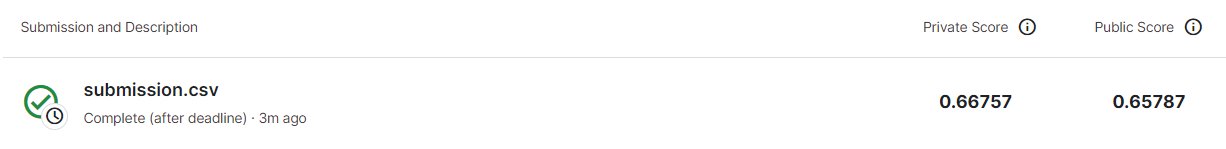